In [179]:
from AddData import add_player_understat_data, add_team_understat_data, add_opp_understat_data
from collections import Counter
import datetime as dt
from GetClubELOData import add_elo
from GetFPLData import load_fpl_data
import GetUnderstatData as getus
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import os
import pandas as pd
import pytz
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
import statsmodels.tools as st
import statsmodels.graphics.api as smg

# Getting the data

The first thing to do here is to get the data that we will be using in the model. The data will come from three sources:
1. Fantasy Premier League API. This provides individual player stats including `total_points`, `bonus`, `
2. Understat
 - Player xG stats
 - Team and opponent xG stats
3. ClubELO.com
 - ELO metrics for clubs
 ,
Having got the data, we set up a model dataframe by using lagged statistics from the previous 4 matches for a player, including their team statistics, as well as statistics about the upcoming opposition and their previous games.

In [186]:
data_dir = "C:/Users/jonat/OneDrive/Documents/Projects/Fantasy Premier League/Data"
seasons = ["{}-{}".format(y, str(y + 1)[2:4]) for y in range(2021, 2023)]

# Find the columns in the FPL data that exist for all seasons of the data
initial = True
for season in seasons:
    fpl_data = load_fpl_data(season)
    
    if initial:
        columns = fpl_data.columns
    
    columns = columns.intersection(fpl_data.columns)
    initial = False

# Create set of FPL data
print("\nLoading FPL data")
fpl_df = pd.DataFrame()
for season in seasons:
    fpl_df1 = load_fpl_data(season)
    fpl_df = pd.concat([fpl_df, fpl_df1[columns]], ignore_index=True)

# Only select data for goalkeepers
fpl_df = fpl_df.loc[fpl_df['element_type'] == 1, :]



Loading FPL data


In [187]:
# Add Understat data to the dataset
print("\nAdding player Understat data")
fpl_df = add_player_understat_data(fpl_df)

# Add team Understat data to the dataframe
print("\nAdding team Understat data")
fpl_df = add_team_understat_data(fpl_df)

# Add team and opposition Elo scores to the dataframe
print("\nAdding ClubELO scores")
fpl_df = add_elo(fpl_df)


Adding player Understat data
2021-22
2022-23

Adding team Understat data
2021-22
2022-23

Adding ClubELO scores


In [188]:
# Make "was_home" numeric
fpl_df['was_home'] = fpl_df.was_home.astype("int")

# Add zeros instead of NaNs in player Understat statistics where the player played zero minutes
player_us_stats = ["shots", "xG", "position", "xA", "key_passes", "npg", "npxG", "xGChain", "xGBuildup"]
fpl_df.loc[fpl_df.minutes == 0, player_us_stats] = 0

In [189]:
# Get player and team lagged statistics
player_lag_stats = ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 
                    'goals_conceded', 'goals_scored', 'ict_index', 'influence', 
                    'minutes', 'own_goals', 'penalties_missed', 'penalties_saved',
                    'red_cards', 'saves', 'selected', 'team_a_score', 
                    'team_h_score', 'threat', 'total_points', 'transfers_in', 
                    'transfers_out', 'value', 'was_home', 'yellow_cards', 
                    'starts', 'shots', 'xG', 'xA', 'key_passes', 'npg', 'npxG', 
                    'xGChain', 'xGBuildup']
team_lag_stats = ['team_xG', 'team_xGA', 'team_npxG', 'team_npxGA', 'team_deep', 
                  'team_deep_allowed', 'team_scored', 'team_missed', 'team_xpts', 
                  'team_wins', 'team_draws', 'team_loses', 'team_ppda_att', 
                  'team_ppda_def', 'team_ppda_allowed_att', 'team_ppda_allowed_def']

lag_stats = player_lag_stats + team_lag_stats

max_lag = 4
lags = range(1, max_lag+1)


In [190]:
for lag in lags:
    lag_colnames = [colname + "_{}".format(lag) for colname in lag_stats]
    
    fpl_df[lag_colnames] = fpl_df.sort_values(by='kickoff_date').groupby(
        ['season_x', 'element'])[lag_stats].shift(lag)
    

C:\Users\jonat\AppData\Local\Temp\ipykernel_30348\3381905693.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fpl_df[lag_colnames] = fpl_df.sort_values(by='kickoff_date').groupby(
C:\Users\jonat\AppData\Local\Temp\ipykernel_30348\3381905693.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fpl_df[lag_colnames] = fpl_df.sort_values(by='kickoff_date').groupby(
C:\Users\jonat\AppData\Local\Temp\ipykernel_30348\3381905693.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

C:\Users\jonat\AppData\Local\Temp\ipykernel_30348\3381905693.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fpl_df[lag_colnames] = fpl_df.sort_values(by='kickoff_date').groupby(
C:\Users\jonat\AppData\Local\Temp\ipykernel_30348\3381905693.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fpl_df[lag_colnames] = fpl_df.sort_values(by='kickoff_date').groupby(
C:\Users\jonat\AppData\Local\Temp\ipykernel_30348\3381905693.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

C:\Users\jonat\AppData\Local\Temp\ipykernel_30348\3381905693.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fpl_df[lag_colnames] = fpl_df.sort_values(by='kickoff_date').groupby(
C:\Users\jonat\AppData\Local\Temp\ipykernel_30348\3381905693.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fpl_df[lag_colnames] = fpl_df.sort_values(by='kickoff_date').groupby(
C:\Users\jonat\AppData\Local\Temp\ipykernel_30348\3381905693.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

C:\Users\jonat\AppData\Local\Temp\ipykernel_30348\3381905693.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fpl_df[lag_colnames] = fpl_df.sort_values(by='kickoff_date').groupby(
C:\Users\jonat\AppData\Local\Temp\ipykernel_30348\3381905693.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fpl_df[lag_colnames] = fpl_df.sort_values(by='kickoff_date').groupby(
C:\Users\jonat\AppData\Local\Temp\ipykernel_30348\3381905693.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

In [191]:
# Add opposition lagged statistics
opp_df = fpl_df[['kickoff_date', 'opp_team_name']].drop_duplicates()
opp_keys = zip(opp_df.kickoff_date, opp_df.opp_team_name)

team_lagged_colnames = [stat + "_{}".format(lag) for lag in lags for stat in team_lag_stats]
opp_lagged_colnames = [colname.replace("team", "opp") for colname in team_lagged_colnames]

for date, opp_name in opp_keys:
    opp_lagged_stats = fpl_df.loc[((fpl_df.kickoff_date == date) & 
                                        (fpl_df.team_x == opp_name)), 
                                       team_lagged_colnames].drop_duplicates()
    
    # Select row with fewest null values
    min_na_idx = opp_lagged_stats.isna().astype(int).sum(axis=1).idxmin()
    
    fpl_df.loc[((fpl_df.kickoff_date == date) & (fpl_df.opp_team_name == opp_name)), 
                 opp_lagged_colnames] = opp_lagged_stats.loc[min_na_idx].tolist()


In [192]:
fpl_df['has_na'] = fpl_df.isna().any(axis=1)
row_hasna = fpl_df.has_na.value_counts()
print("Rows containing null values: {}".format(row_hasna[True]))
print("Rows not containing null values: {}".format(row_hasna[False]))
print("{:.1f}% of rows contain null values".format(100*row_hasna[True]/row_hasna.sum()))

Rows containing null values: 668
Rows not containing null values: 5033
11.7% of rows contain null values


In [215]:
model_df = fpl_df.copy().dropna(axis=0)
excl_df = fpl_df.drop(model_df.index, axis=0)

In [216]:
starters = fpl_df.loc[fpl_df.starts == 1].index
non_starters = fpl_df.loc[fpl_df.starts == 0].index

# Exploring the data

We are interested in examining the difference in points distribution between starting players and substitutes. The figure below shows clearly that there are significant differences between the distributions of points for starters and non-starters.

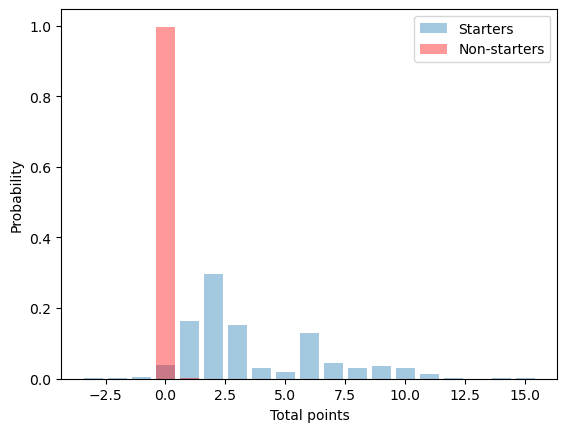

In [217]:
# Look at the difference in returns between starters and non-starters
tp_s = fpl_df.loc[starters, "total_points"].value_counts()
tp_s = tp_s/tp_s.sum()
tp_ns = fpl_df.loc[non_starters, "total_points"].value_counts()
tp_ns = tp_ns/tp_ns.sum()

fig, ax = plt.subplots()
ax.bar(tp_s.index, tp_s.values, alpha=0.4, label="Starters")
ax.bar(tp_ns.index, tp_ns.values, alpha=0.4, label="Non-starters", color='r')
ax.set_xlabel("Total points")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

The summary statistics for the distributions are shown in the table below.

|  | Starters | Non-starters |
| --- | --- | --- |
| Mean | 3.608 | 0.005 |
| Variance | 8.190 | 0.020 |

In light of such differing distributions for starters and non-starters, we aim to predict the points scored by a player given that they start in a match. Then, it will be a question of assigning a probability to the chance that a player starts a match in order to determine their expected score. This will not currently be within the scope of this project although

In [218]:
s_mean = sum(tp_s.index * tp_s.values)
ns_mean = sum(tp_ns.index * tp_ns.values)
s_var = sum(tp_s.values * (tp_s.index**2)) - s_mean**2
ns_var = sum(tp_ns.values * ((tp_ns.index - ns_mean)**2))
print("Mean for starters = {:.3f}".format(s_mean))
print("Mean for non-starters = {:.3f}".format(ns_mean))
print("Variance for starters = {:.3f}".format(s_var))
print("Variance for non-starters = {:.3f}".format(ns_var))

Mean for starters = 3.608
Mean for non-starters = 0.005
Variance for starters = 8.190
Variance for non-starters = 0.020


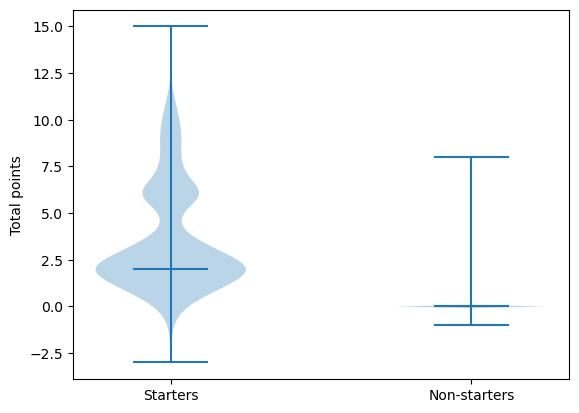

In [219]:
# Create a violin plot of total_points returns for starters and non-starters
fig, ax = plt.subplots()
ax.violinplot([fpl_df.loc[starters, 'total_points'], fpl_df.loc[non_starters, 'total_points']],
             showmedians=True)
ax.set_xticks([1, 2], labels=["Starters", "Non-starters"])
ax.set_ylabel("Total points")
plt.show()

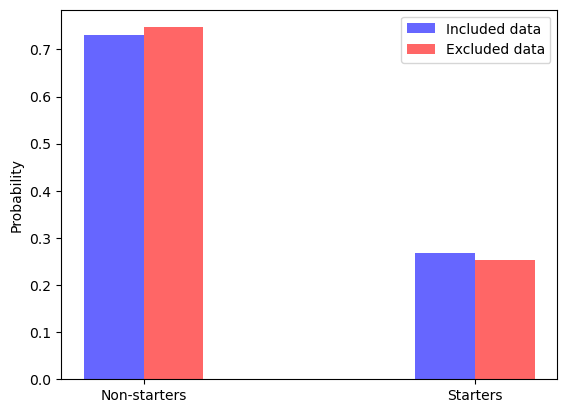

In [234]:
# Compare the percentages of starters in the included and excluded data
starts_inc = model_df['starts'].value_counts()
starts_inc = starts_inc/starts_inc.sum()
starts_exc = excl_df['starts'].value_counts()
starts_exc = starts_exc/starts_exc.sum()

bar_width = 0.18
x_inc = [1 - 0.5*bar_width, 2 - 0.5*bar_width]
x_exc = [1 + 0.5*bar_width, 2 + 0.5*bar_width]
fig, ax = plt.subplots()
ax.bar(x_inc, starts_inc.values, width=bar_width, color='b', alpha=0.6, label="Included data")
ax.bar(x_exc, starts_exc.values, width=bar_width, color='r', alpha=0.6, label="Excluded data")
ax.set_xticks([1, 2], ["Non-starters", "Starters"])
ax.set_ylabel("Probability")
ax.legend()
plt.show()

In [198]:
# Drop players who did not start from the model dataframe
model_df.drop(model_df.loc[model_df.starts == 0].index, axis=0, inplace=True)

In [199]:
# Create new features
def create_feature_cols(df):
    df1 = df.drop_duplicates(["element"])
    df1['transfers_in_pct'] = 100*df1.transfers_in/df1.transfers_in.sum()
    df1['transfers_out_pct'] = 100*df1.transfers_out/df1.transfers_out.sum()
    df1['transfers_balance_rank'] = df1.transfers_balance.rank()
    df = df.merge(df1[['element', 'transfers_in_pct', 'transfers_out_pct', 'transfers_balance_rank']],
                  how='left',
                  on='element')
    return df[['element', 'transfers_in_pct', 'transfers_out_pct', 'transfers_balance_rank']]

new_features_df = model_df.groupby(["season_x", "round"]).apply(create_feature_cols)

In [200]:
new_features_df.index = new_features_df.index.droplevel(2)
new_features_df.reset_index(inplace=True)

In [201]:
model_df = pd.merge(model_df, new_features_df)
model_df.drop_duplicates(inplace=True)

In [202]:
# Get some response vs regressor plots and add new features
model_df['clean_sheet_ratio'] = model_df[["clean_sheets_{}".format(x) for x in range(1, 5)]].mean(axis=1)
model_df['opp_xG_avg'] = model_df[["opp_xG_{}".format(x) for x in range(1, 5)]].mean(axis=1)
model_df['opp_G_avg'] = model_df[["opp_scored_{}".format(x) for x in range(1, 5)]].mean(axis=1)

plot_regressors = (['selected', 'transfers_in', 'transfers_out', 'value', 'was_home', 'team_elo', 'opp_elo', 
                    'transfers_balance', 'transfers_balance_rank', 'transfers_in_pct', 'transfers_out_pct', 'diff_elo', 
                    'clean_sheet_ratio', 'opp_xG_avg', 'opp_G_avg'] + 
                   ['team_ppda_allowed_def_{}'.format(x) for x in range(1, 5)] + 
                   ['opp_ppda_allowed_def_{}'.format(x) for x in range(1, 5)])

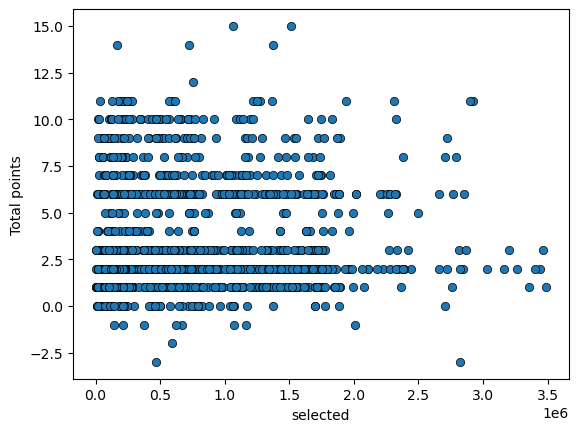

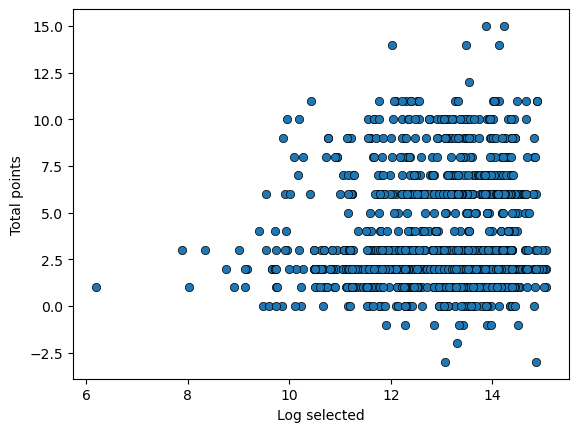

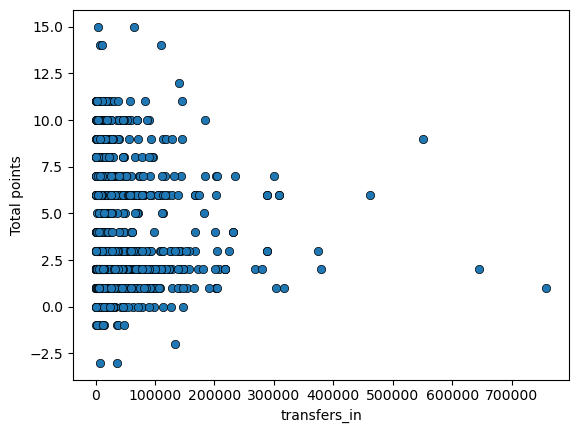

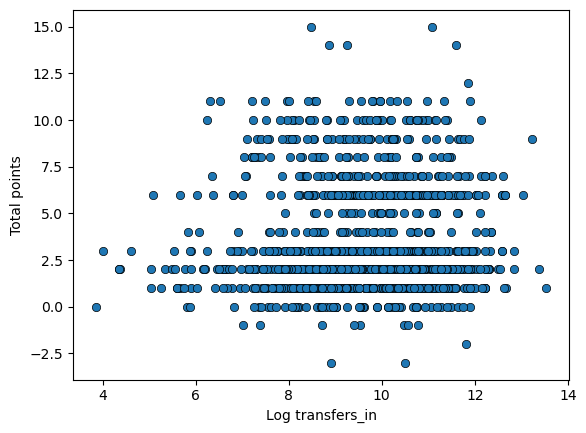

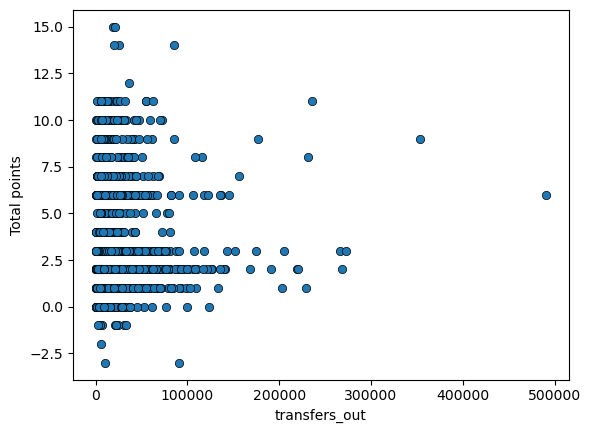

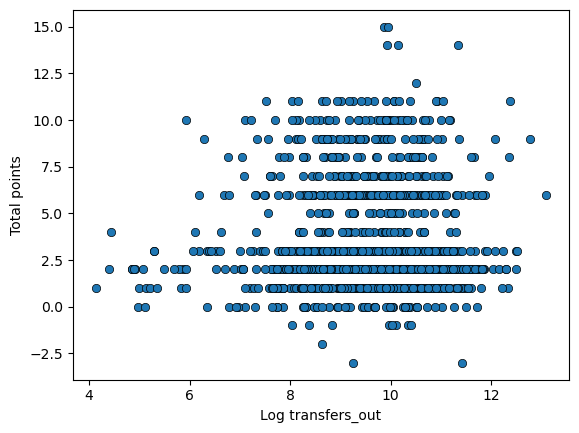

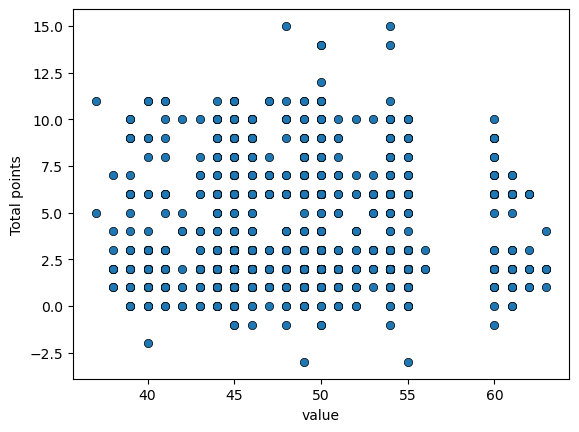

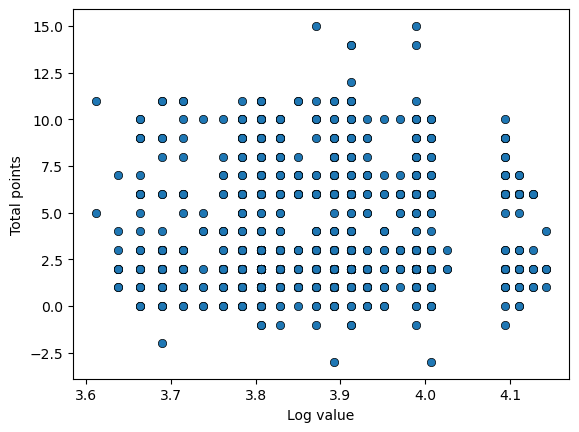

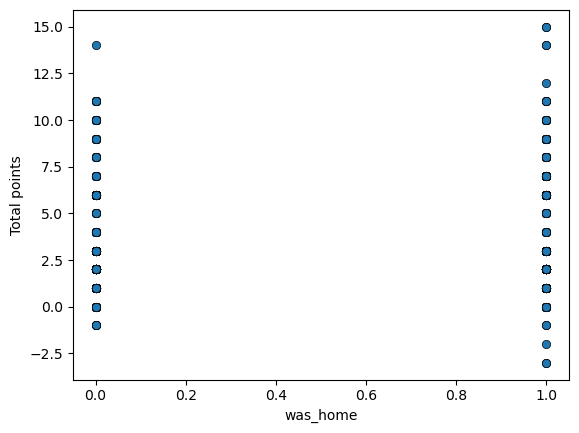

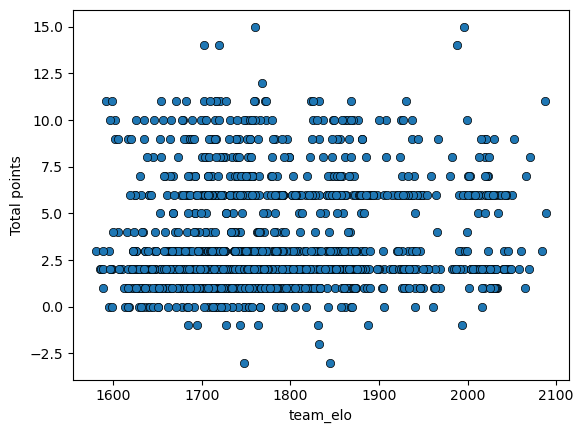

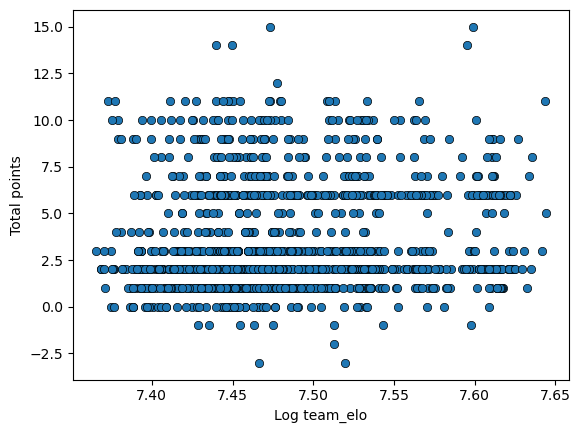

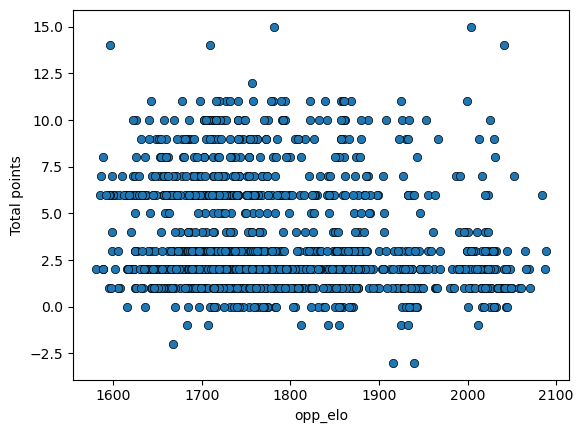

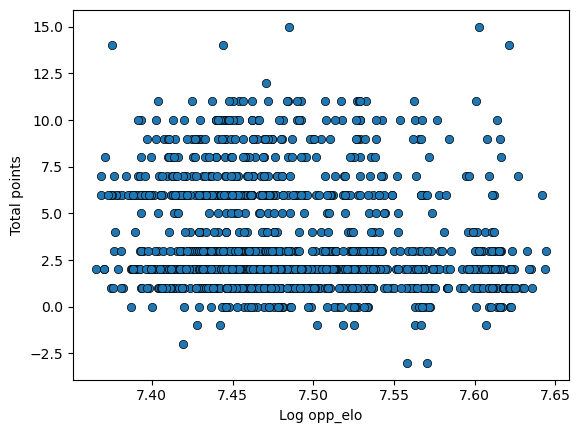

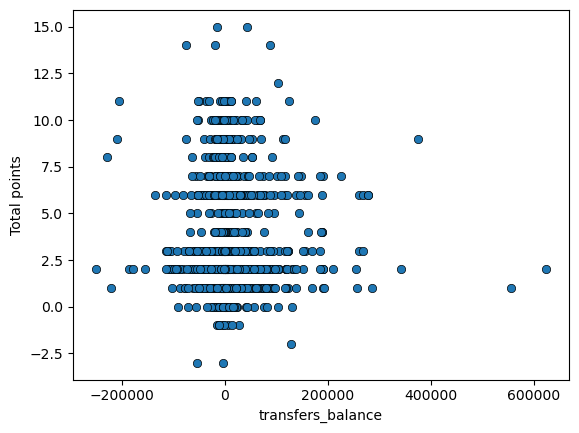

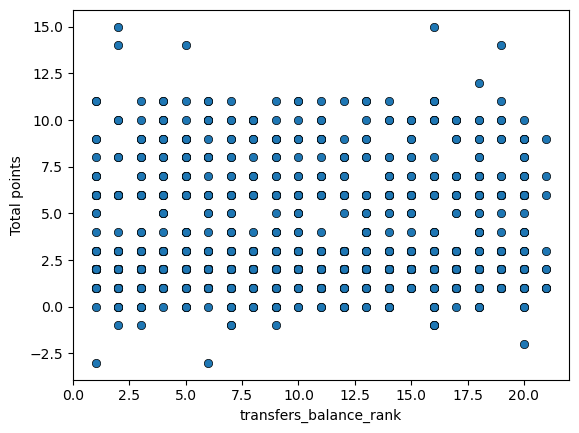

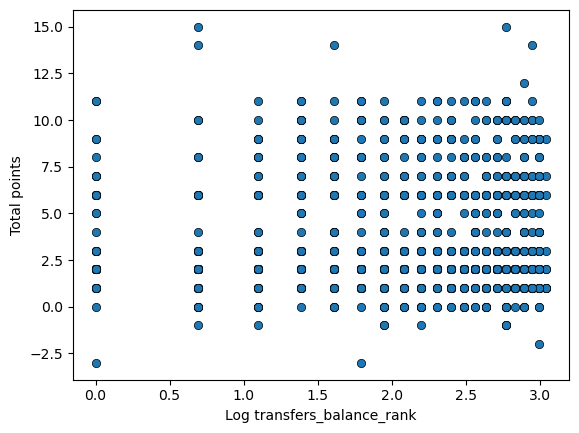

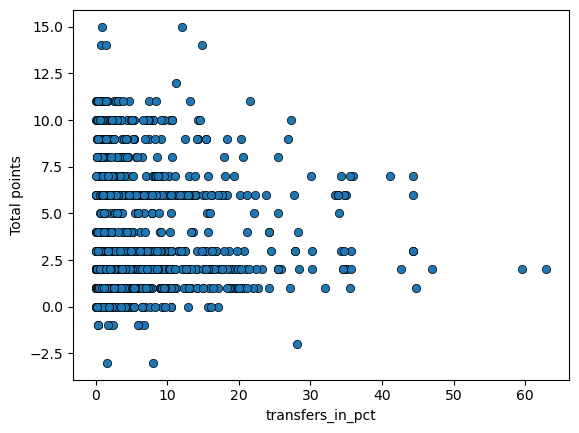

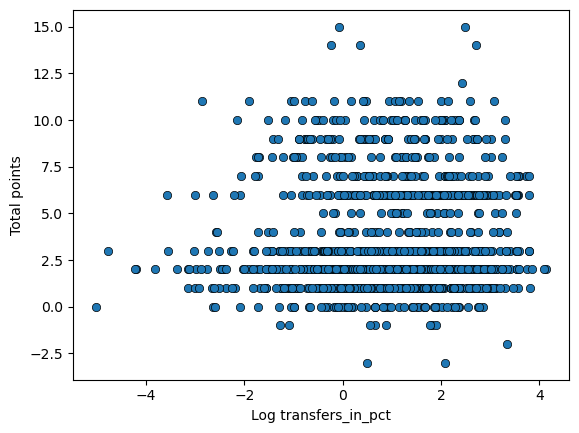

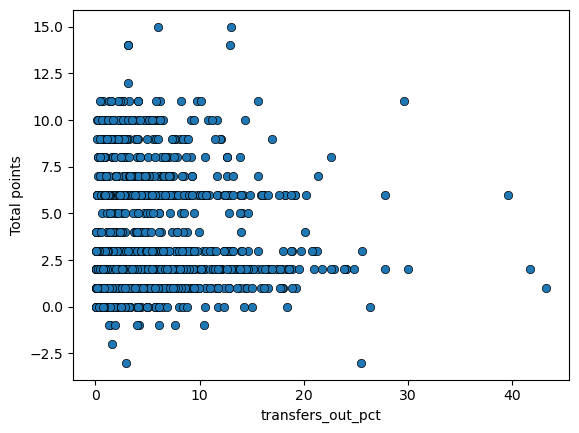

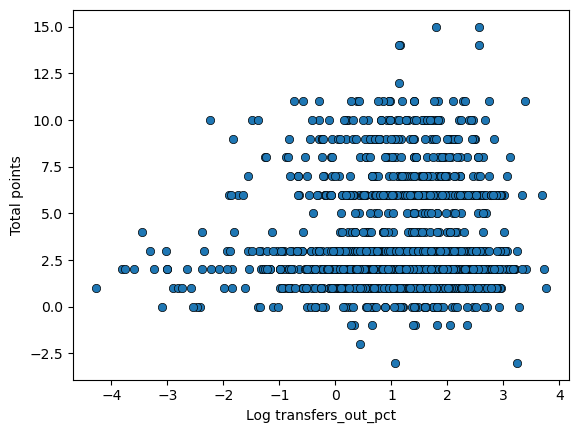

KeyError: 'diff_elo'

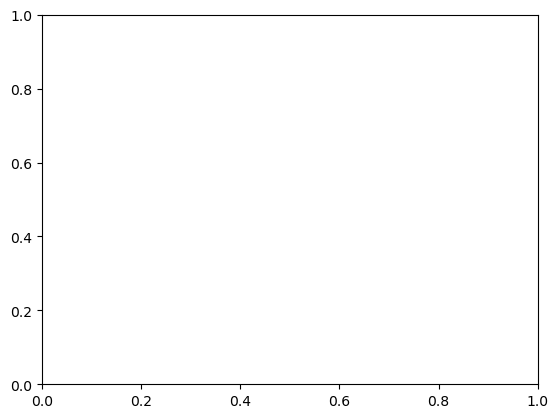

In [203]:
for regressor in plot_regressors:
    fig, ax = plt.subplots()
    ax.scatter(model_df[regressor], model_df['total_points'], edgecolor='k', linewidths=0.5)
    ax.set_xlabel(regressor)
    ax.set_ylabel("Total points")
    plt.show()
    
    if (model_df[regressor] > 0).all():
        fig, ax = plt.subplots()
        ax.scatter(np.log(model_df[regressor].astype(float)), model_df['total_points'], edgecolor='k', linewidths=0.5)
        ax.set_xlabel(("Log " + regressor))
        ax.set_ylabel("Total points")
        plt.show()

In [ ]:
# Add some transformed explanatory variables
log_variables = ['selected', 'transfers_in', 'transfers_out', 'transfers_in_pct', 'transfers_out_pct']
for var in log_variables:
    log_var = "log_" + var
    model_df[log_var] = np.log(model_df[var])

In [ ]:
# Add some second-order variable interactions with "was_home" and "diff_elo"
# was_home_x_vars = ['selected', 'transfers_in', 'transfers_out', 'value', 'team_elo', 'opp_elo', 'transfers_balance', 
#                    'transfers_balance_rank', 'transfers_in_pct', 'transfers_out_pct', 'diff_elo', 'clean_sheet_ratio', 
#                    'opp_xG_avg', 'opp_G_avg']
# diff_elo_x_vars = ['selected', 'transfers_in', 'transfers_out', 'value', 'was_home', 'team_elo', 'opp_elo', 
#                     'transfers_balance', 'transfers_balance_rank', 'transfers_in_pct', 'transfers_out_pct',
#                     'clean_sheet_ratio', 'opp_xG_avg', 'opp_G_avg']

# for var in was_home_x_vars:
#     new_var_name = "was_home_x_" + var
#     model_df[new_var_name] = model_df['was_home'] * model_df[var]
    
# for var in diff_elo_x_vars:
#     new_var_name = "diff_elo_x_" + var
#     model_df[new_var_name] = model_df['diff_elo'] * model_df[var]

In [ ]:
# Sort the dataframe by time
model_df.sort_values("kickoff_date", ascending=True)

# Drop columns that will not be used in the models
drop_cols = ['element', 'fixture', 'kickoff_time', 'opponent_team', 'round',
             'transfers_balance', 'name', 'season_x', 'opp_team_name', 
             'kickoff_datetime', 'kickoff_date', 'team_x', 'element_type', 
             'position', 'team_npxGD', 'team_result', 'team_pts', 'expected_goals_conceded',
             'expected_assists', 'expected_goal_involvements', 'expected_goals']

keep_stats = ['total_points', 'selected', 'transfers_in', 'transfers_out', 'value',
              'was_home']
drop_stats = list(set(lag_stats) - set(keep_stats))

model_df.drop((drop_cols + drop_stats), axis=1, inplace=True, errors='ignore')

# Set all remaining columns to be numeric
model_df = model_df.astype(float)

In [ ]:
# Split into a test set and a training set
n_obs = model_df.shape[0]
model_df.index = range(len(model_df))
test_frac = 0.2
test_size = int(np.round(n_obs * test_frac))

test_idx = model_df.index[(len(model_df) - test_size):]

test = model_df.loc[test_idx]
train = model_df.drop(test_idx, axis=0)

# Split response and predictor
y_train = train.total_points
y_test = test.total_points
X_train = train.drop("total_points", axis=1)
X_test = test.drop("total_points", axis=1)

In [ ]:
print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)

In [ ]:
# Normalize the design matrices
X_mean = X_train.mean()
X_std = X_train.std()
X_train = ((X_train - X_mean)/X_std).fillna((X_train - X_mean))
X_test = ((X_test - X_mean)/X_std).fillna((X_test - X_mean))

# Drop any constant columns
const_cols = X_train.loc[:, (X_train == 0).all(0)].columns
X_train.drop(const_cols, axis=1, inplace=True)
X_test.drop(const_cols, axis=1, inplace=True)

In [ ]:
# Add constant term
X_train = sm.add_constant(X_train, has_constant="add")
X_test = sm.add_constant(X_test, has_constant="add")

In [ ]:
# Fit OLS regression model
model = sm.OLS(y_train, X_train)
res = model.fit()

print(res.summary())

In [ ]:
resid = res.resid_pearson

# QQ plot for residuals
fig = sm.qqplot(resid)
a = np.linspace(-3, 3, 2)
plt.plot(a, a, color='black', linestyle='--')
plt.show()

In [ ]:
# Plot of standardized residuals vs fitted values
fitted_values = res.fittedvalues
fig, ax = plt.subplots()
ax.scatter(fitted_values, resid, edgecolors='black', linewidths=0.5)
ax.set_xlabel("Fitted values")
ax.set_ylabel("Standardised residuals")
plt.show()

In [ ]:
# Plot of fitted values vs response
fig, ax = plt.subplots()
ax.scatter(y_train, fitted_values, edgecolor='k', linewidths=0.5)
ax.set_xlabel("Response")
ax.set_ylabel("Fitted values")
ax.set_axisbelow(True)
plt.grid()
plt.show()

In [ ]:
# Get predicted values for the test data
X_test = X_test[X_train.columns]
test_fitted_values = res.predict(X_test)
test_resid = test_fitted_values - y_test

In [ ]:
# Plot of fitted values vs actual values
fig, ax = plt.subplots()
ax.scatter(y_test, test_fitted_values, edgecolor='k', linewidths=0.5)
ax.set_xlabel("Response")
ax.set_ylabel("Fitted values")
plt.show()

In [ ]:
# Plot of residuals vs fitted values
fig, ax = plt.subplots()
ax.scatter(test_fitted_values, test_resid, edgecolor='k', linewidths=0.5)
ax.set_xlabel("Fitted values")
ax.set_ylabel("Raw residuals")

In [ ]:
# Compute OOS MAE and MSE
mae = np.mean(abs(test_resid))
mse = np.mean(test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(mae, mse))

In [ ]:
# Remove negative outliers from the response, shift and apply Box-Cox transform
negative_responses = y_train.loc[y_train < 0].index
y_train_tr = y_train.drop(negative_responses)
X_train_tr = X_train.drop(negative_responses, axis=0)

In [ ]:
y_train_tr = y_train_tr + 1
y_train_tr, tr_lambda = stats.boxcox(y_train_tr)

In [ ]:
# Fit OLS regression model
model_tr = sm.OLS(y_train_tr, X_train_tr)
res_tr = model_tr.fit()

print(res_tr.summary())

In [ ]:
resid_tr = res_tr.resid_pearson

# QQ plot for residuals
fig = sm.qqplot(resid_tr)
a = np.linspace(-3, 3, 2)
plt.plot(a, a, color='black', linestyle='--')
plt.show()

In [ ]:
# Plot of standardized residuals vs fitted values
fitted_values_tr = res_tr.fittedvalues
fig, ax = plt.subplots()
ax.scatter(fitted_values_tr, resid_tr, edgecolors='black', linewidths=0.5)
ax.set_xlabel("Fitted values")
ax.set_ylabel("Standardised residuals")
plt.show()

In [ ]:
# Plot of fitted values vs response
fig, ax = plt.subplots()
ax.scatter(y_train_tr, fitted_values_tr, edgecolor='k', linewidths=0.5)
ax.set_xlabel("Response")
ax.set_ylabel("Fitted values")
ax.set_axisbelow(True)
plt.grid()
plt.show()

In [ ]:
# Check for highly correlated columns in the design matrix
corr_mat = X_train.corr()
corr_threshold = 0.85
is_corr = (corr_mat >= corr_threshold)
for i in range(is_corr.shape[0]):
    for j in range(i+1, is_corr.shape[1]):
        if is_corr.iloc[i, j]:
            print("[{}, {}]".format(is_corr.index[i], is_corr.columns[j]))

In [ ]:
# Drop highly correlated columns
drop_cols = (["opp_npxGA_{}".format(x) for x in range(1, 5)] +
             ["opp_npxG_{}".format(x) for x in range(1, 5)] + 
             ["team_npxG_{}".format(x) for x in range(1, 5)] + 
             ["team_npxGA_{}".format(x) for x in range(1, 5)] +
             ["selected_{}".format(x) for x in range(1, 5)] + 
             ["value_{}".format(x) for x in range(1, 5)] + 
             ["influence_{}".format(x) for x in range(1, 5)] + 
             ["ict_index_{}".format(x) for x in range(1, 5)] +
             ["creativity_{}".format(x) for x in range(1, 5)] + 
             ["threat_{}".format(x) for x in range(1, 5)] +
             ["xGBuildup_{}".format(x) for x in range(1, 5)] + 
             ["npg_{}".format(x) for x in range(1, 5)] + 
             ["npxG_{}".format(x) for x in range(1, 5)] + 
             ["team_missed_{}".format(x) for x in range(1, 5)] + 
             ["bps_{}".format(x) for x in range(1, 5)] + 
             ["shots_{}".format(x) for x in range(1, 5)] + 
             ["assists_{}".format(x) for x in range(1, 5)] + 
             ["red_cards_{}".format(x) for x in range(1, 5)] + 
             ["starts_{}".format(x) for x in range(1, 5)]
            )

In [ ]:
X_train2 = X_train.drop(drop_cols, axis=1, errors='ignore')
X_test2 = X_test.drop(drop_cols, axis=1, errors='ignore')

In [ ]:
# Check for highly correlated columns in the design matrix
corr_mat = X_train2.corr()
is_corr = (corr_mat >= corr_threshold)
for i in range(is_corr.shape[0]):
    for j in range(i+1, is_corr.shape[1]):
        if is_corr.iloc[i, j]:
            print("[{}, {}] : {:.3f}".format(is_corr.index[i], is_corr.columns[j], corr_mat.iloc[i, j]))

In [ ]:
# Fit new model
model2 = sm.OLS(y_train, X_train2)
res2 = model2.fit()

print(res2.summary())

In [ ]:
resid_2 = res2.resid_pearson

# QQ plot for residuals
fig = sm.qqplot(resid_2)
a = np.linspace(-3, 3, 2)
plt.plot(a, a, color='black', linestyle='--')
plt.show()

In [ ]:
# Plot of standardized residuals vs fitted values
fitted_values_2 = res2.fittedvalues
fig, ax = plt.subplots()
ax.scatter(fitted_values_2, resid_2, edgecolors='black', linewidths=0.5)
ax.set_xlabel("Fitted values")
ax.set_ylabel("Standardised residuals")
plt.show()

In [ ]:
# Plot of fitted values vs response
fig, ax = plt.subplots()
ax.scatter(y_train, fitted_values_2, edgecolor='k', linewidths=0.5)
ax.set_xlabel("Response")
ax.set_ylabel("Fitted values")
ax.set_axisbelow(True)
plt.grid()
plt.show()

In [ ]:
# Get predicted values for the test data
X_test2 = X_test[X_train2.columns]
test_fitted_values_2 = res2.predict(X_test2)
test_resid_2 = test_fitted_values_2 - y_test

In [ ]:
# Plot of fitted values vs actual values
fig, ax = plt.subplots()
ax.scatter(y_test, test_fitted_values_2, edgecolor='k', linewidths=0.5)
ax.set_xlabel("Response")
ax.set_ylabel("Fitted values")
plt.show()

Text(0, 0.5, 'Raw residuals')

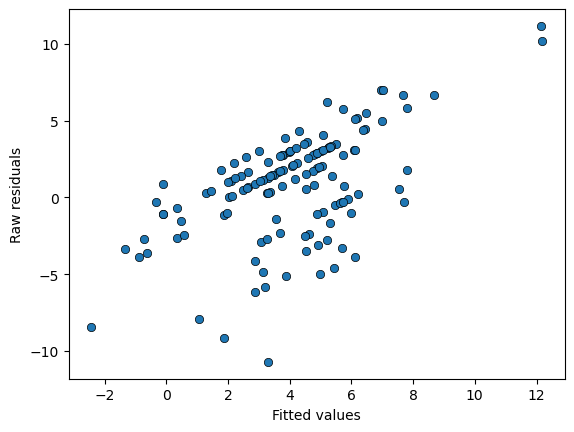

In [153]:
# Plot of residuals vs fitted values
fig, ax = plt.subplots()
ax.scatter(test_fitted_values_2, test_resid_2, edgecolor='k', linewidths=0.5)
ax.set_xlabel("Fitted values")
ax.set_ylabel("Raw residuals")

In [154]:
# Compute OOS MAE and MSE
mae = np.mean(abs(test_resid_2))
mse = np.mean(test_resid_2**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(mae, mse))

MAE: 2.786
MSE: 12.748


In [155]:
X_train.columns.tolist()

['const',
 'selected',
 'transfers_in',
 'transfers_out',
 'value',
 'was_home',
 'team_elo',
 'opp_elo',
 'assists_1',
 'bonus_1',
 'bps_1',
 'clean_sheets_1',
 'creativity_1',
 'goals_conceded_1',
 'ict_index_1',
 'influence_1',
 'minutes_1',
 'own_goals_1',
 'penalties_saved_1',
 'red_cards_1',
 'saves_1',
 'selected_1',
 'team_a_score_1',
 'team_h_score_1',
 'threat_1',
 'total_points_1',
 'transfers_in_1',
 'transfers_out_1',
 'value_1',
 'was_home_1',
 'yellow_cards_1',
 'starts_1',
 'shots_1',
 'xG_1',
 'xA_1',
 'key_passes_1',
 'npxG_1',
 'xGChain_1',
 'xGBuildup_1',
 'team_xG_1',
 'team_xGA_1',
 'team_npxG_1',
 'team_npxGA_1',
 'team_deep_1',
 'team_deep_allowed_1',
 'team_scored_1',
 'team_missed_1',
 'team_xpts_1',
 'team_wins_1',
 'team_draws_1',
 'team_loses_1',
 'team_ppda_att_1',
 'team_ppda_def_1',
 'team_ppda_allowed_att_1',
 'team_ppda_allowed_def_1',
 'assists_2',
 'bonus_2',
 'bps_2',
 'clean_sheets_2',
 'creativity_2',
 'goals_conceded_2',
 'ict_index_2',
 'influen

In [156]:
# Perform stepwise backward selection, removing columns whose coefficients are not significantly different from zero
priority_list = ['log_selected', 'log_transfers_in', 'log_transfers_out', 'log_transfers_in_pct', 'log_transfers_out_pct', 'selected', 'transfers_in', 'transfers_out', 'transfers_in_pct', 'transfers_out_pct', 'transfers_balance_rank', 'value', 'was_home', 'team_elo', 'opp_elo', 'diff_elo', 'clean_sheet_ratio', 'opp_xG_avg', 'opp_G_avg', 'assists_1', 'bonus_1', 'clean_sheets_1', 'goals_scored_1', 'goals_conceded_1', 'minutes_1', 'own_goals_1', 'penalties_saved_1', 'red_cards_1', 'saves_1', 'team_a_score_1', 'team_h_score_1', 'total_points_1', 'transfers_in_1', 'transfers_out_1', 'was_home_1', 'yellow_cards_1', 'xG_1', 'xA_1', 'key_passes_1', 'xGChain_1', 'team_xG_1', 'team_xGA_1', 'team_deep_1', 'team_deep_allowed_1', 'team_scored_1', 'team_xpts_1', 'team_wins_1', 'team_draws_1', 'team_loses_1', 'team_ppda_att_1', 'team_ppda_def_1', 'team_ppda_allowed_att_1', 'team_ppda_allowed_def_1', 'opp_xG_1', 'opp_xGA_1', 'opp_deep_1', 'opp_deep_allowed_1', 'opp_scored_1', 'opp_missed_1', 'opp_xpts_1', 'opp_wins_1', 'opp_draws_1', 'opp_loses_1', 'opp_ppda_att_1', 'opp_ppda_def_1', 'opp_ppda_allowed_att_1', 'opp_ppda_allowed_def_1', 'assists_2', 'bonus_2', 'clean_sheets_2', 'goals_scored_2', 'goals_conceded_2', 'minutes_2', 'own_goals_2', 'penalties_saved_2', 'red_cards_2', 'saves_2', 'team_a_score_2', 'team_h_score_2', 'total_points_2', 'transfers_in_2', 'transfers_out_2', 'was_home_2', 'yellow_cards_2', 'xG_2', 'xA_2', 'key_passes_2', 'xGChain_2', 'team_xG_2', 'team_xGA_2', 'team_deep_2', 'team_deep_allowed_2', 'team_scored_2', 'team_xpts_2', 'team_wins_2', 'team_draws_2', 'team_loses_2', 'team_ppda_att_2', 'team_ppda_def_2', 'team_ppda_allowed_att_2', 'team_ppda_allowed_def_2', 'opp_xG_2', 'opp_xGA_2', 'opp_deep_2', 'opp_deep_allowed_2', 'opp_scored_2', 'opp_missed_2', 'opp_xpts_2', 'opp_wins_2', 'opp_draws_2', 'opp_loses_2', 'opp_ppda_att_2', 'opp_ppda_def_2', 'opp_ppda_allowed_att_2', 'opp_ppda_allowed_def_2', 'assists_3', 'bonus_3', 'clean_sheets_3', 'goals_scored_3', 'goals_conceded_3', 'minutes_3', 'own_goals_3', 'penalties_saved_3', 'red_cards_3', 'saves_3', 'team_a_score_3', 'team_h_score_3', 'total_points_3', 'transfers_in_3', 'transfers_out_3', 'was_home_3', 'yellow_cards_3', 'xG_3', 'xA_3', 'key_passes_3', 'xGChain_3', 'team_xG_3', 'team_xGA_3', 'team_deep_3', 'team_deep_allowed_3', 'team_scored_3', 'team_xpts_3', 'team_wins_3', 'team_draws_3', 'team_loses_3', 'team_ppda_att_3', 'team_ppda_def_3', 'team_ppda_allowed_att_3', 'team_ppda_allowed_def_3', 'opp_xG_3', 'opp_xGA_3', 'opp_deep_3', 'opp_deep_allowed_3', 'opp_scored_3', 'opp_missed_3', 'opp_xpts_3', 'opp_wins_3', 'opp_draws_3', 'opp_loses_3', 'opp_ppda_att_3', 'opp_ppda_def_3', 'opp_ppda_allowed_att_3', 'opp_ppda_allowed_def_3', 'assists_4', 'bonus_4', 'clean_sheets_4', 'goals_scored_4', 'goals_conceded_4', 'minutes_4', 'own_goals_4', 'penalties_saved_4', 'red_cards_4', 'saves_4', 'team_a_score_4', 'team_h_score_4', 'total_points_4', 'transfers_in_4', 'transfers_out_4', 'was_home_4', 'yellow_cards_4', 'starts_4', 'xG_4', 'xA_4', 'key_passes_4', 'xGChain_4', 'team_xG_4', 'team_xGA_4', 'team_deep_4', 'team_deep_allowed_4', 'team_scored_4', 'team_xpts_4', 'team_wins_4', 'team_draws_4', 'team_loses_4', 'team_ppda_att_4', 'team_ppda_def_4', 'team_ppda_allowed_att_4', 'team_ppda_allowed_def_4', 'opp_xG_4', 'opp_xGA_4', 'opp_deep_4', 'opp_deep_allowed_4', 'opp_scored_4', 'opp_missed_4', 'opp_xpts_4', 'opp_wins_4', 'opp_draws_4', 'opp_loses_4', 'opp_ppda_att_4', 'opp_ppda_def_4', 'opp_ppda_allowed_att_4', 'opp_ppda_allowed_def_4']
priority_list.reverse()

dropped_cols = []
X_train_temp = X_train2.copy()
selection_complete = False
p_value_threshold = 0.1

while not selection_complete:
    model_temp = sm.OLS(y_train, X_train_temp)
    res_temp = model_temp.fit()
    drop_candidates = res_temp.pvalues.loc[res_temp.pvalues > p_value_threshold]
    if len(drop_candidates) == 0:
        selection_complete = True
        continue
    
    drop_col = priority_list.pop([col in drop_candidates for col in priority_list].index(True))
    print("{}: {:.3f}".format(drop_col, drop_candidates.loc[drop_col]))
    dropped_cols.append(drop_col)
    X_train_temp.drop(drop_col, axis=1, inplace=True)

opp_ppda_allowed_def_4: 0.836
opp_ppda_def_4: 0.716
opp_loses_4: 0.684
opp_draws_4: 0.464
opp_wins_4: 0.728
opp_xpts_4: 0.341
opp_ppda_att_4: 0.103
opp_ppda_allowed_att_4: 0.102
opp_missed_4: 0.470
opp_deep_allowed_4: 0.353
opp_deep_4: 0.149
opp_xGA_4: 0.733
opp_xG_4: 0.424
team_ppda_allowed_def_4: 0.649
team_ppda_allowed_att_4: 0.507
team_ppda_def_4: 0.679
team_ppda_att_4: 0.367
team_loses_4: 0.720
team_draws_4: 0.846
team_wins_4: 0.703
team_xpts_4: 0.136
team_deep_allowed_4: 0.573
team_xGA_4: 0.953
xGChain_4: 0.840
key_passes_4: 0.388
xA_4: 0.443
xG_4: 0.997
yellow_cards_4: 0.507
was_home_4: 0.566
transfers_in_4: 0.803
total_points_4: 0.613
saves_4: 0.818
own_goals_4: 0.449
minutes_4: 0.285
goals_conceded_4: 0.171
team_h_score_4: 0.256
team_scored_4: 0.233
team_xG_4: 0.131
team_deep_4: 0.104
team_a_score_4: 0.623
clean_sheets_4: 0.548
opp_ppda_allowed_def_3: 0.230
opp_ppda_allowed_att_3: 0.852
opp_ppda_def_3: 0.566
opp_ppda_att_3: 0.993
opp_loses_3: 0.414
opp_wins_3: 0.933
opp_xpts_3

In [157]:
# Examine model chosen by backward selection

X_train_bs = sm.add_constant(X_train_temp)
model_bs = sm.OLS(y_train, X_train_bs)
res_bs = model_bs.fit()

print(res_bs.summary())

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     3.280
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           2.83e-08
Time:                        09:43:31   Log-Likelihood:                -1311.1
No. Observations:                 540   AIC:                             2684.
Df Residuals:                     509   BIC:                             2817.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

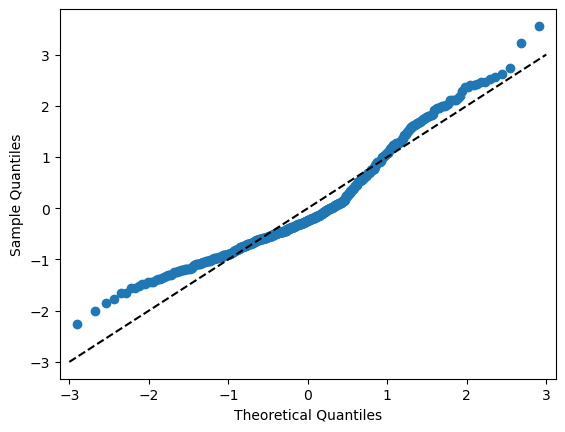

In [158]:
resid_bs = res_bs.resid_pearson

# QQ plot for residuals
fig = sm.qqplot(resid_bs)
a = np.linspace(-3, 3, 2)
plt.plot(a, a, color='black', linestyle='--')
plt.show()

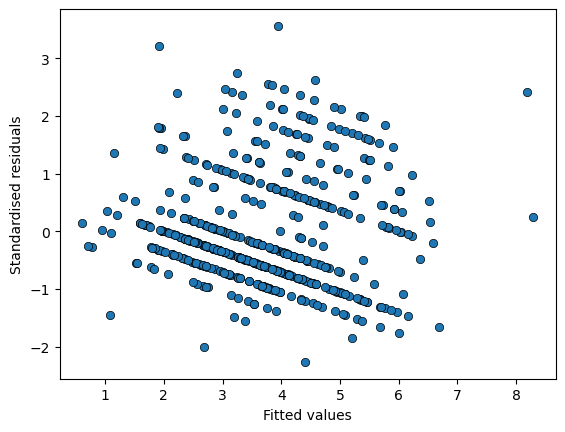

In [159]:
# Plot of standardized residuals vs fitted values
fitted_values_bs = res_bs.fittedvalues
fig, ax = plt.subplots()
ax.scatter(fitted_values_bs, resid_bs, edgecolors='black', linewidths=0.5)
ax.set_xlabel("Fitted values")
ax.set_ylabel("Standardised residuals")
plt.show()

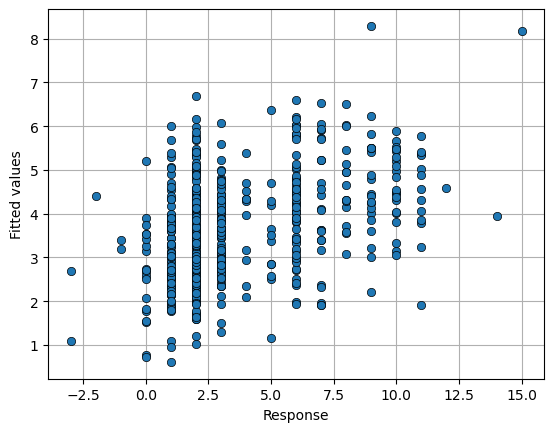

In [160]:
# Plot of fitted values vs response
fig, ax = plt.subplots()
ax.scatter(y_train, fitted_values_bs, edgecolor='k', linewidths=0.5)
ax.set_xlabel("Response")
ax.set_ylabel("Fitted values")
ax.set_axisbelow(True)
plt.grid()
plt.show()

C:\Users\jonat\AppData\Local\Temp\ipykernel_30348\3216224720.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


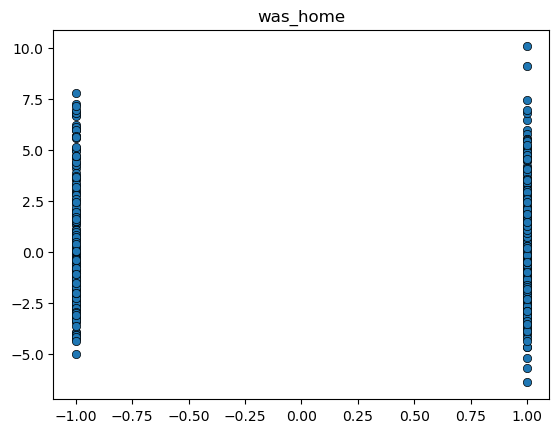

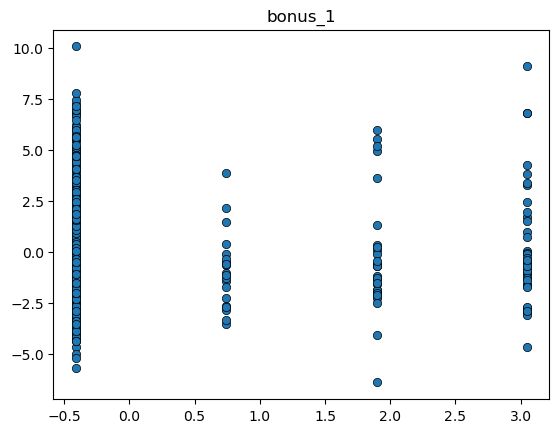

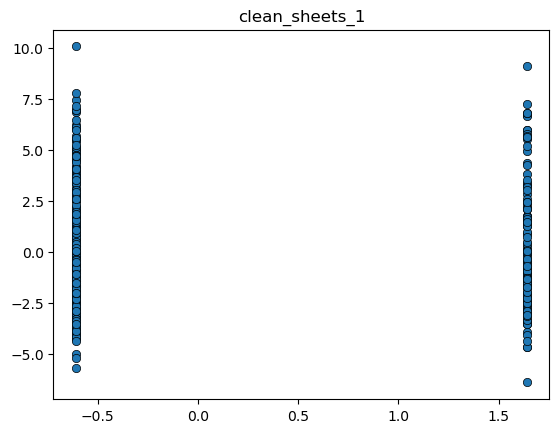

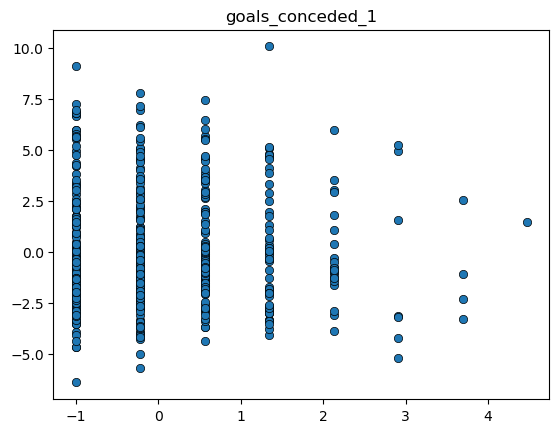

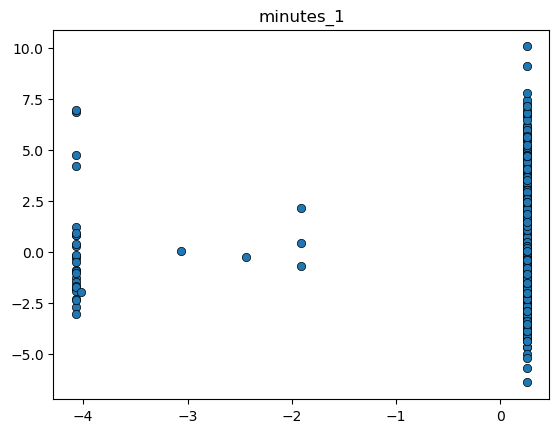

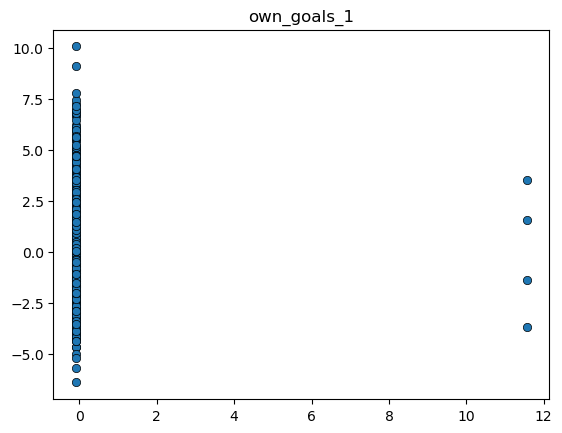

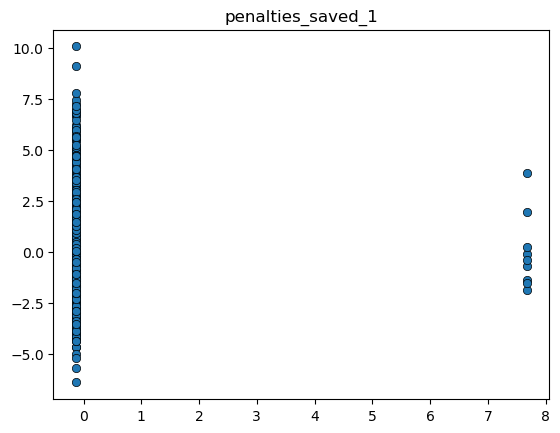

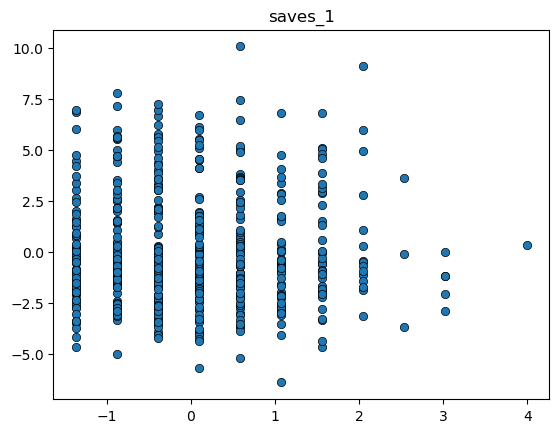

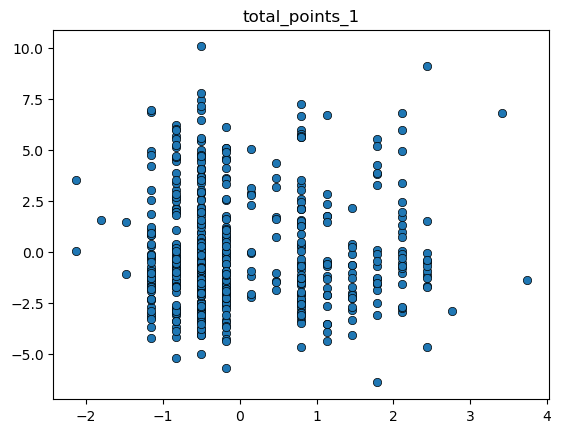

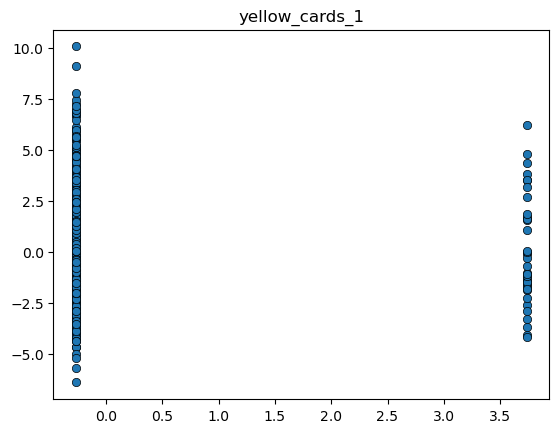

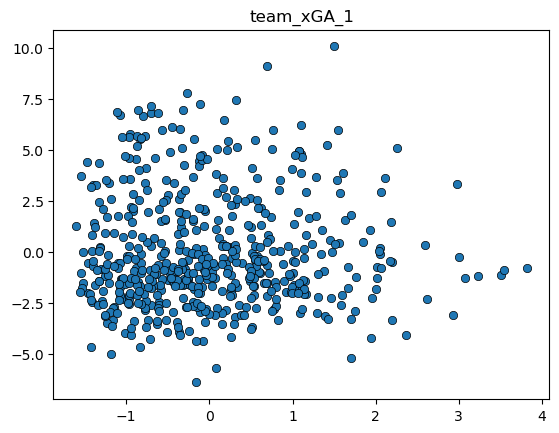

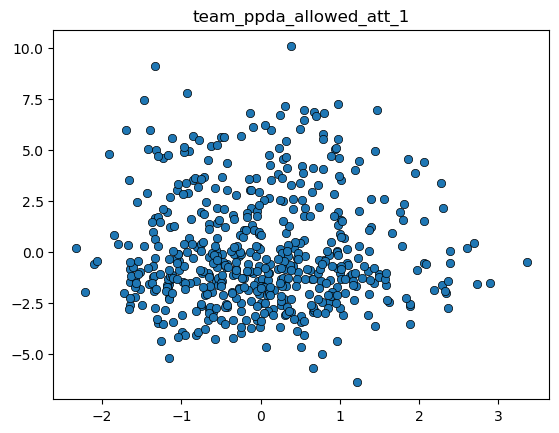

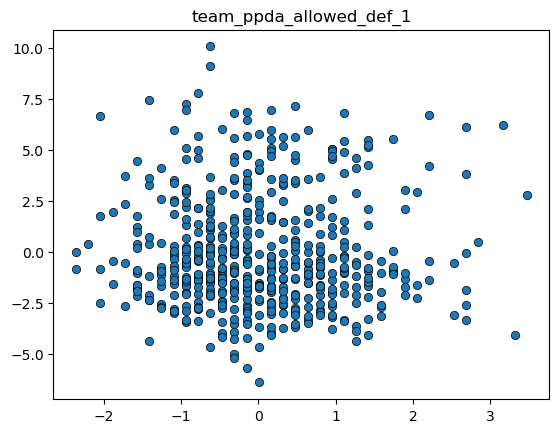

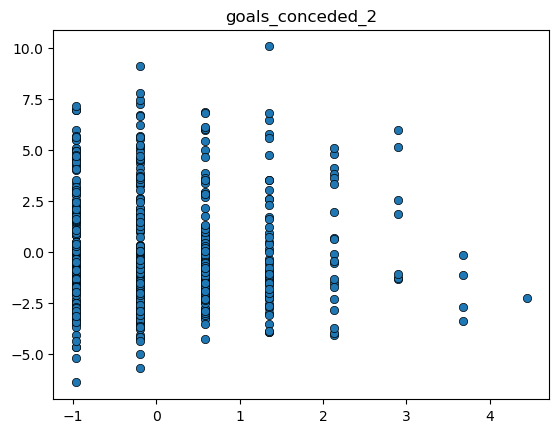

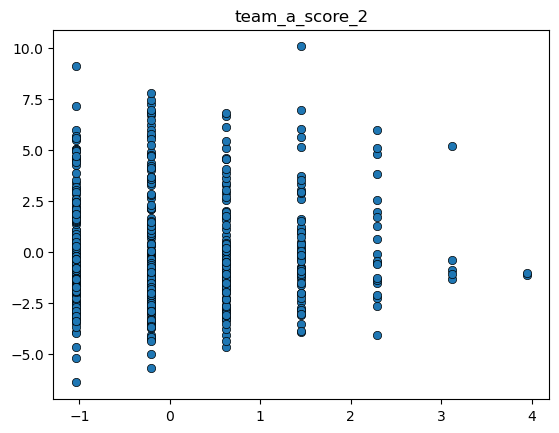

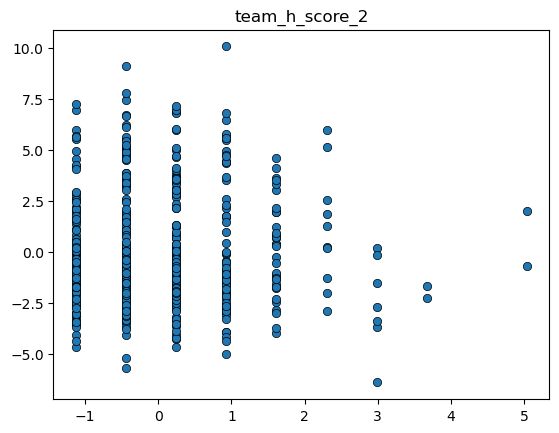

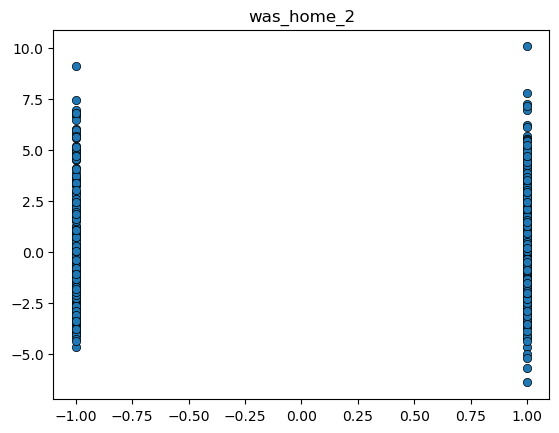

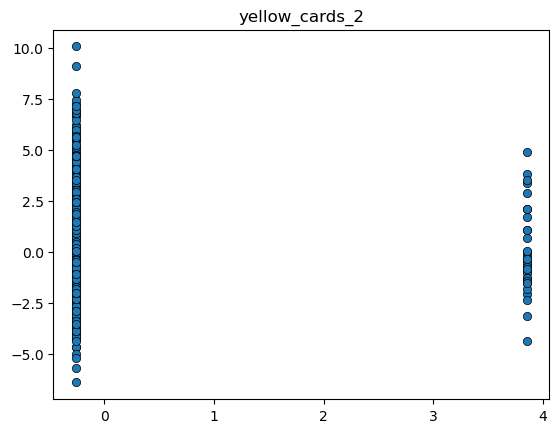

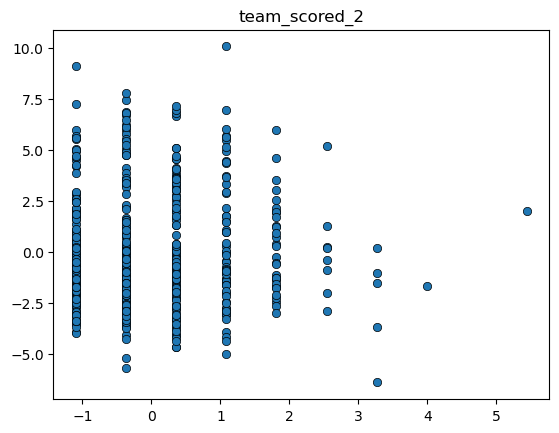

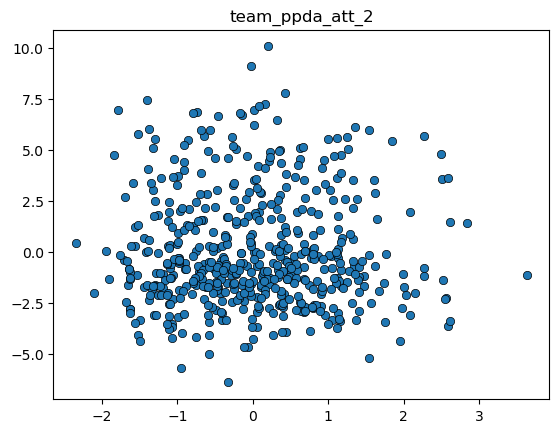

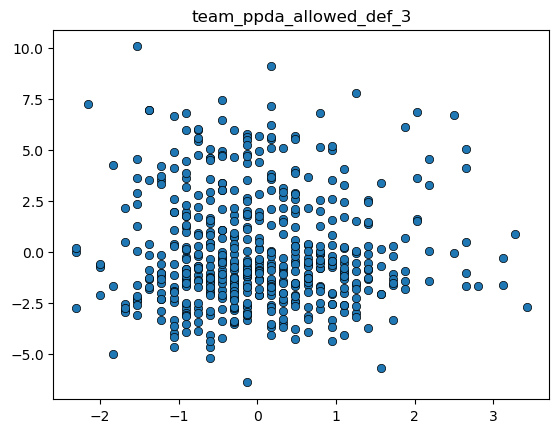

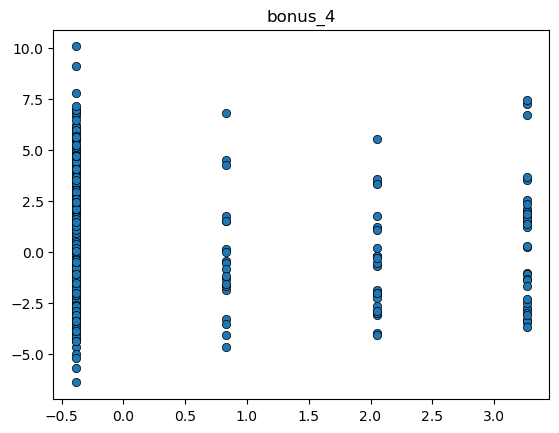

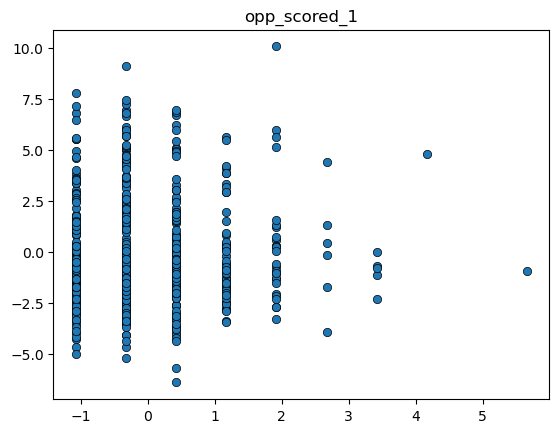

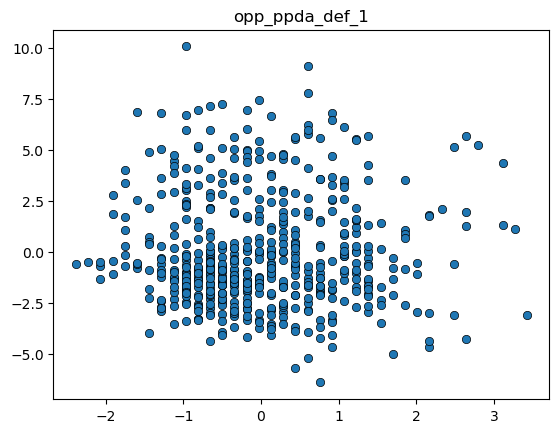

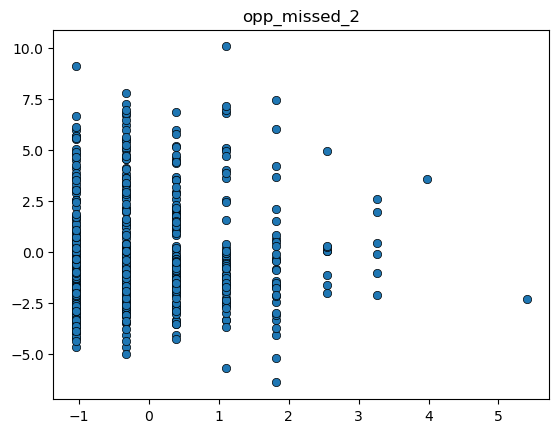

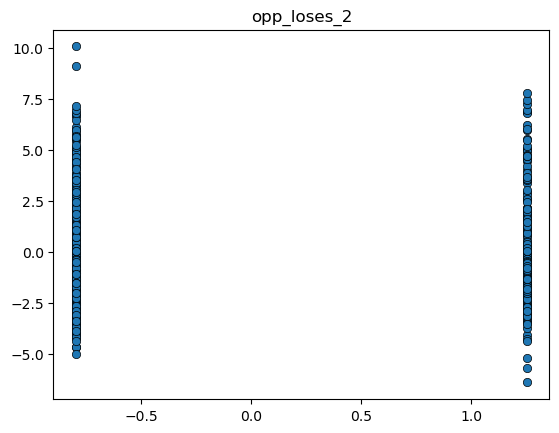

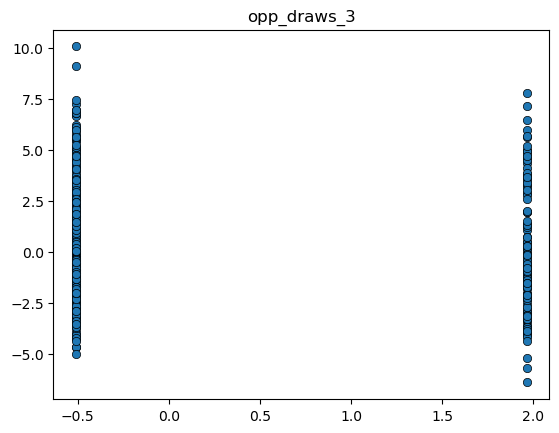

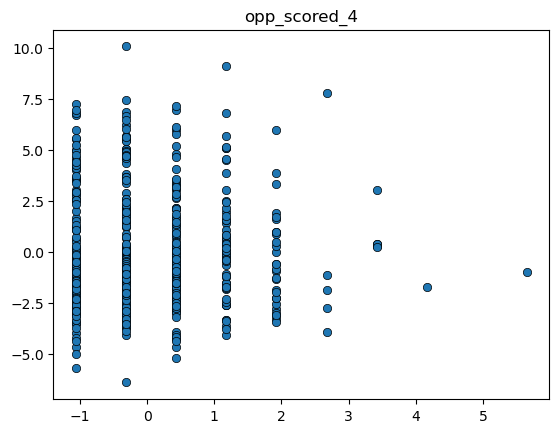

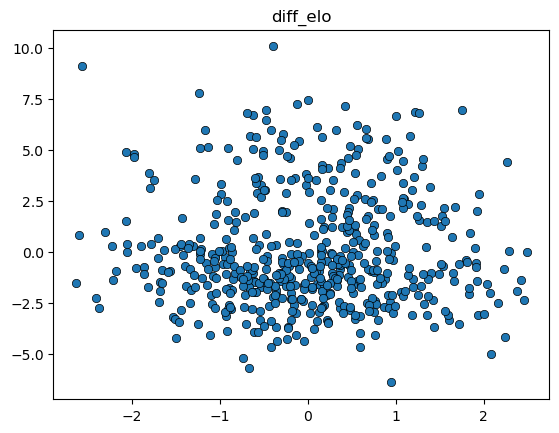

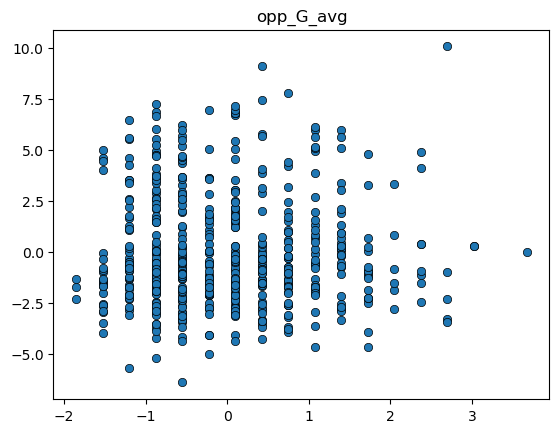

In [161]:
# Create residual vs regressor plots
for col in X_train_bs.columns[1:]:
    fig, ax = plt.subplots()
    ax.set_title(col)
    ax.scatter(X_train_bs[col], res_bs.resid, edgecolor='k', linewidths=0.5)

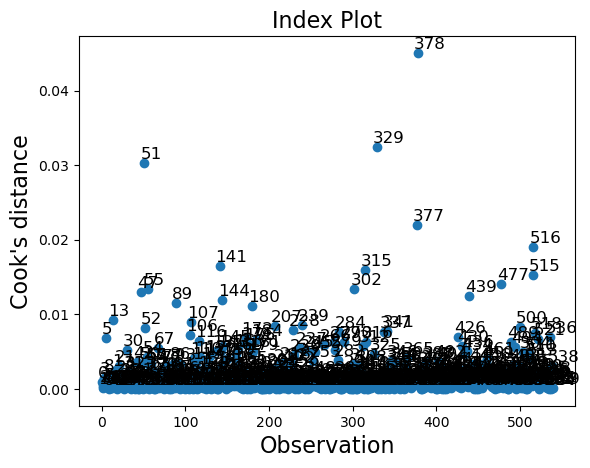

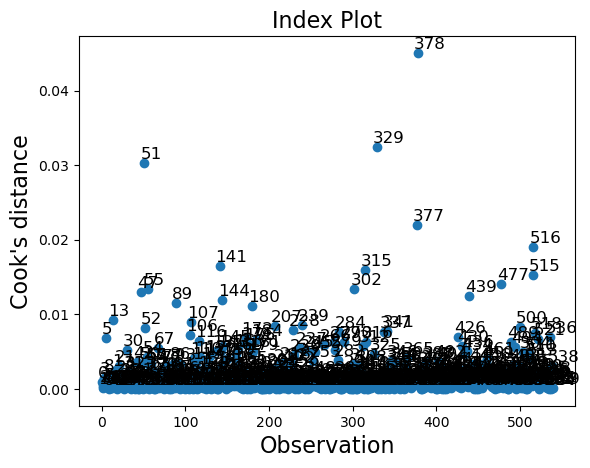

In [162]:
# Check for leverage points and outliers
res_bs.get_influence().plot_index()

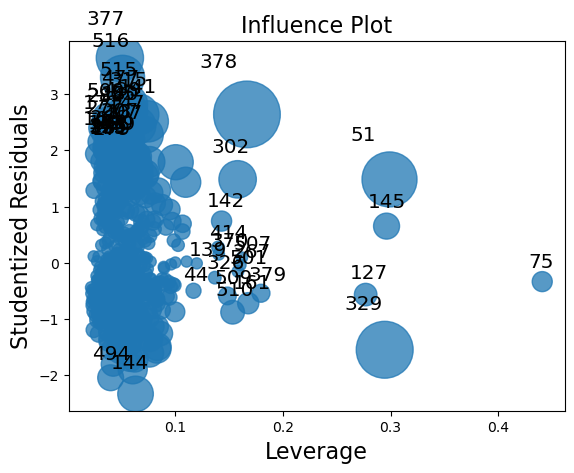

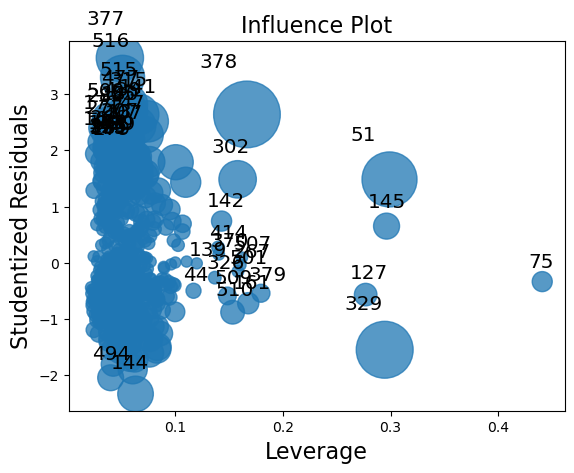

In [163]:
res_bs.get_influence().plot_influence()

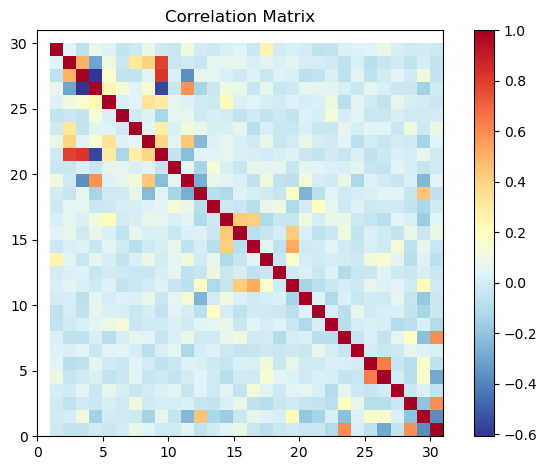

In [164]:
corr_matrix_bs = X_train_bs.corr()
smg.plot_corr(corr_matrix_bs)
plt.show()

In [165]:
# Try the backward selection model on the test data
X_test_bs = X_test.loc[:, X_train_temp.columns]
X_test_bs['const'] = 1.0
X_test_bs = X_test_bs[X_train_bs.columns]

test_bs_fitted_values = res_bs.predict(X_test_bs)
test_bs_resid = test_bs_fitted_values - y_test

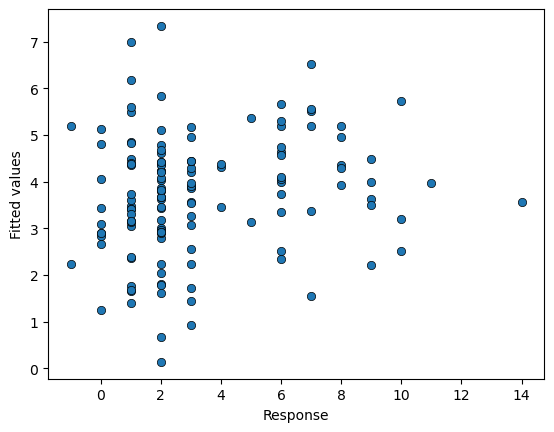

In [166]:
# Plot of fitted values vs actual values
fig, ax = plt.subplots()
ax.scatter(y_test, test_bs_fitted_values, edgecolor='k', linewidths=0.5)
ax.set_xlabel("Response")
ax.set_ylabel("Fitted values")
plt.show()

Text(0, 0.5, 'Raw residuals')

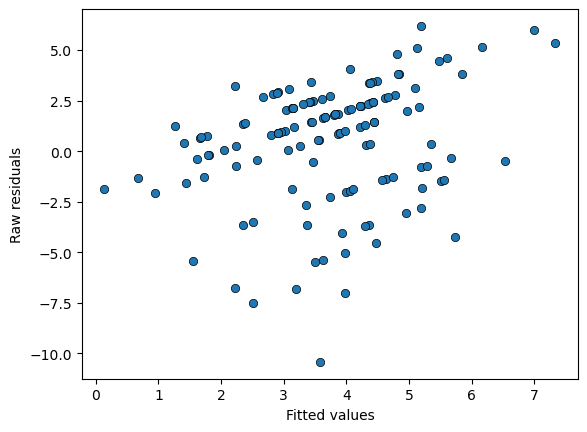

In [167]:
# Plot of residuals vs fitted values
fig, ax = plt.subplots()
ax.scatter(test_bs_fitted_values, test_bs_resid, edgecolor='k', linewidths=0.5)
ax.set_xlabel("Fitted values")
ax.set_ylabel("Raw residuals")

In [168]:
# Compute OOS MAE and MSE
mae_bs = np.mean(abs(test_bs_resid))
mse_bs = np.mean(test_bs_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(mae_bs, mse_bs))

MAE: 2.393
MSE: 8.880


In [169]:
# Run a lasso regression implementing 20-fold cross-validation for the selection of the tuning parameter

def split(a, n):
    k = len(a) // n
    q = len(a) % n
    return [a[(i*k + min(i, q)):(i+1)*k + 1 + min(i, q-1)] for i in range(n)]

In [170]:
validation_idxs = split(X_train2.sample(frac=1).index, 20)

In [171]:
alpha_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
lasso_cv_error_dict = {}
for a in alpha_list:
    print(a)
    lasso_cv_error_dict[a] = []
    for i, idx in enumerate(validation_idxs):
        X_test_cv = X_train2.loc[idx]
        y_test_cv = y_train[idx]
        X_train_cv = X_train2.drop(idx, axis=0)
        y_train_cv = y_train.drop(idx)
        
        model_lasso = sm.OLS(y_train_cv, X_train_cv)
        res_lasso = model_lasso.fit_regularized(alpha=a, L1_wt=1)
        
        cv_fitted_vals = res_lasso.predict(X_test_cv)
        lasso_cv_error_dict[a] += (cv_fitted_vals - y_test_cv).tolist()
    

1e-06
1e-05
0.0001
0.001
0.01
0.1
1
10


In [172]:
lasso_cv_mae = []
lasso_cv_mse = []
for a in alpha_list:
    lasso_cv_mae.append(np.mean(abs(np.array(lasso_cv_error_dict[a]))))
    lasso_cv_mse.append(np.mean(np.array(lasso_cv_error_dict[a])**2))

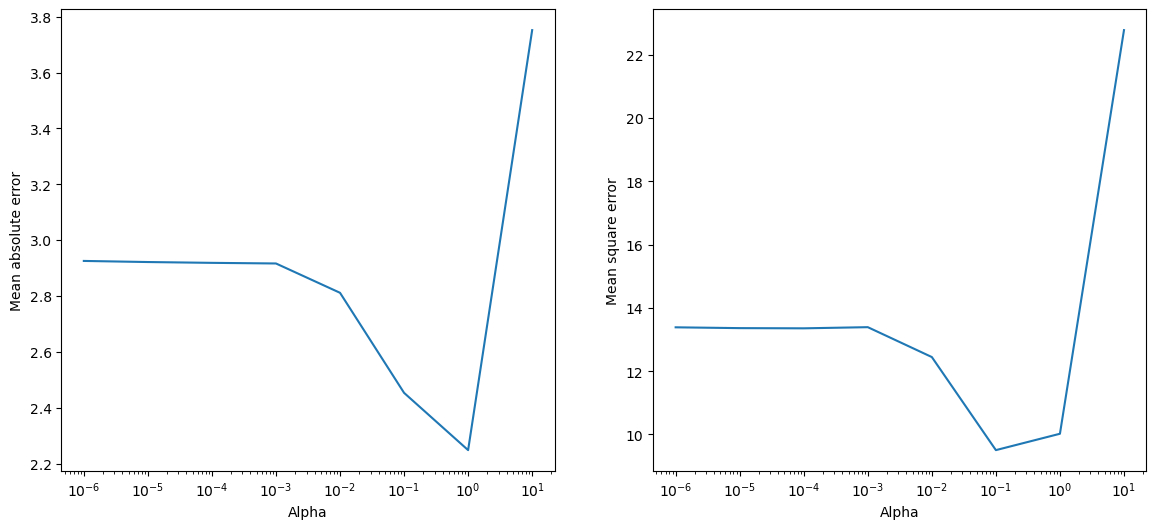

In [173]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(alpha_list, lasso_cv_mae)
ax1.set_xscale("log")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Mean absolute error")
ax2.plot(alpha_list, lasso_cv_mse)
ax2.set_xscale("log")
ax2.set_xlabel("Alpha")
ax2.set_ylabel("Mean square error")
plt.show()

In [174]:
alpha_lasso = 0.1

model_lasso = sm.OLS(y_train, X_train2)
res_lasso = model_lasso.fit_regularized(alpha=alpha_lasso, L1_wt=1)

In [175]:
lasso_test_fitted_values = res_lasso.predict(X_test2)
lasso_test_resid = lasso_test_fitted_values - y_test

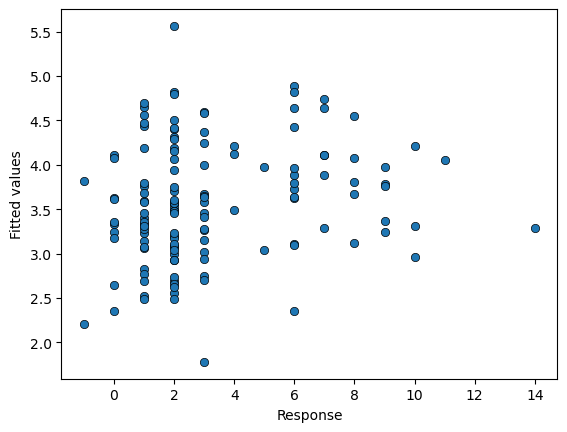

In [176]:
# Plot of fitted values vs actual values
fig, ax = plt.subplots()
ax.scatter(y_test, lasso_test_fitted_values, edgecolor='k', linewidths=0.5)
ax.set_xlabel("Response")
ax.set_ylabel("Fitted values")
plt.show()

Text(0, 0.5, 'Raw residuals')

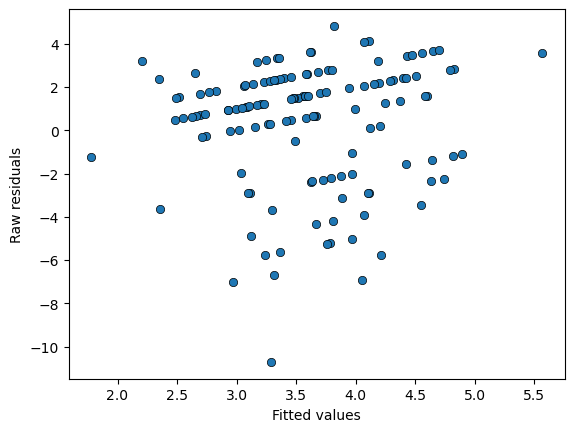

In [177]:
# Plot of residuals vs fitted values
fig, ax = plt.subplots()
ax.scatter(lasso_test_fitted_values, lasso_test_resid, edgecolor='k', linewidths=0.5)
ax.set_xlabel("Fitted values")
ax.set_ylabel("Raw residuals")

In [178]:
# Compute OOS MAE and MSE
mae_lasso = np.mean(abs(lasso_test_resid))
mse_lasso = np.mean(lasso_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(mae_lasso, mse_lasso))

MAE: 2.332
MSE: 8.138


In [505]:
alpha_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
ridge_cv_error_dict = {}
for a in alpha_list:
    print(a)
    ridge_cv_error_dict[a] = []
    for i, idx in enumerate(validation_idxs):
        X_test_cv = X_train2.loc[idx]
        y_test_cv = y_train[idx]
        X_train_cv = X_train2.drop(idx, axis=0)
        y_train_cv = y_train.drop(idx)
        
        model_ridge = sm.OLS(y_train_cv, X_train_cv)
        res_ridge = model_ridge.fit_regularized(alpha=a, L1_wt=0)
        
        cv_fitted_vals = res_ridge.predict(X_test_cv)
        ridge_cv_error_dict[a] += (cv_fitted_vals - y_test_cv).tolist()
    

1e-06
1e-05
0.0001
0.001
0.01
0.1
1


In [506]:
ridge_cv_mae = []
ridge_cv_mse = []
for a in alpha_list:
    ridge_cv_mae.append(np.mean(abs(np.array(ridge_cv_error_dict[a]))))
    ridge_cv_mse.append(np.mean(np.array(ridge_cv_error_dict[a])**2))

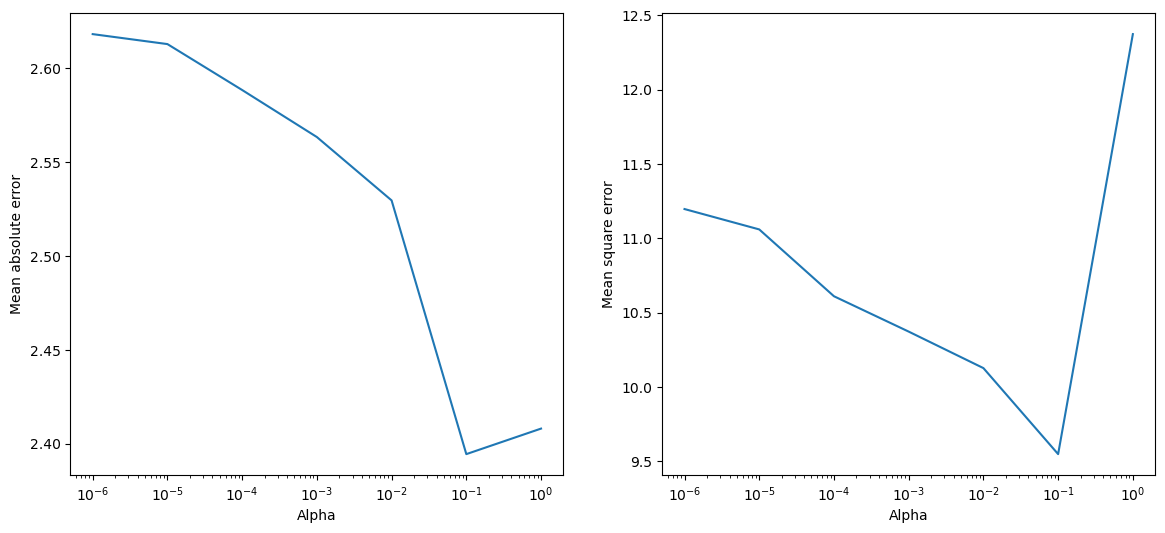

In [507]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(alpha_list, ridge_cv_mae)
ax1.set_xscale("log")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Mean absolute error")
ax2.plot(alpha_list, ridge_cv_mse)
ax2.set_xscale("log")
ax2.set_xlabel("Alpha")
ax2.set_ylabel("Mean square error")
plt.show()

In [513]:
alpha_ridge = 0.1

model_ridge = sm.OLS(y_train, X_train2)
res_ridge = model_ridge.fit_regularized(alpha=alpha_ridge, L1_wt=1)

In [514]:
ridge_test_fitted_values = res_ridge.predict(X_test2)
ridge_test_resid = ridge_test_fitted_values - y_test

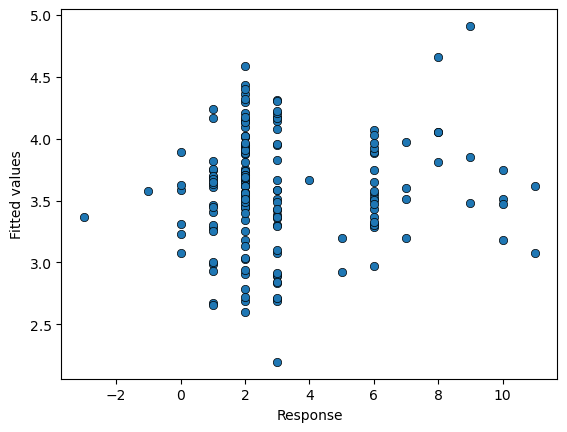

In [515]:
# Plot of fitted values vs actual values
fig, ax = plt.subplots()
ax.scatter(y_test, ridge_test_fitted_values, edgecolor='k', linewidths=0.5)
ax.set_xlabel("Response")
ax.set_ylabel("Fitted values")
plt.show()

Text(0, 0.5, 'Raw residuals')

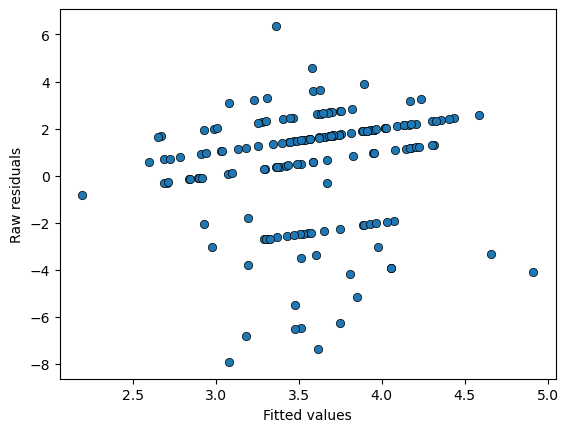

In [516]:
# Plot of residuals vs fitted values
fig, ax = plt.subplots()
ax.scatter(ridge_test_fitted_values, ridge_test_resid, edgecolor='k', linewidths=0.5)
ax.set_xlabel("Fitted values")
ax.set_ylabel("Raw residuals")

In [517]:
# Compute OOS MAE and MSE
mae_ridge = np.mean(abs(ridge_test_resid))
mse_ridge = np.mean(ridge_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(mae_ridge, mse_ridge))

MAE: 2.099
MSE: 6.466


In [518]:
# Implement a random forest regression

# Begin by performing cross-validation to test on the appropriate depth of the tree and the number of iterators to use
max_depth = [2, 3, 4, 5, 6, 10, 20]
n_estimators = [10, 100, 1000]
mae_rf_cv = {}
mse_rf_cv = {}
validation_sets = split(X_train2.sample(frac=1).index, 10)
for n in n_estimators:
    mae_rf_cv[n] = {'train': [], 'test': []}
    mse_rf_cv[n] = {'train': [], 'test': []}
    for depth in max_depth:
        print("depth: {}, no. of estimators: {}".format(depth, n))
        cv_train_mae = []
        cv_train_mse = []
        cv_val_mae = []
        cv_val_mse = []

        for validation_idxs in validation_sets:
            X_train_rf_cv = X_train2.drop(validation_idxs, axis=0)
            y_train_rf_cv = y_train.drop(validation_idxs)
            X_validation_rf_cv = X_train2.loc[validation_idxs]
            y_validation_rf_cv = y_train.loc[validation_idxs]
            
            regr = RandomForestRegressor(max_depth=depth, random_state=0, oob_score=True, n_estimators=n)
            regr.fit(X_train_rf_cv, y_train_rf_cv)

            predict_train = regr.predict(X_train_rf_cv)
            predict_val = regr.predict(X_validation_rf_cv)

            resid_train = predict_train - y_train_rf_cv
            resid_test = predict_val - y_validation_rf_cv
            
            cv_train_mae.append(np.mean(abs(resid_train)))
            cv_train_mse.append(np.mean(resid_train**2))
            cv_val_mae.append(np.mean(abs(resid_test)))
            cv_val_mse.append(np.mean(resid_test**2))

        mae_rf_cv[n]['train'].append(np.mean(cv_train_mae))
        mse_rf_cv[n]['train'].append(np.mean(cv_train_mse))
        mae_rf_cv[n]['test'].append(np.mean(cv_val_mae))
        mse_rf_cv[n]['test'].append(np.mean(cv_val_mse))



depth: 2, no. of estimators: 10


C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probab

depth: 3, no. of estimators: 10


C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probab

depth: 4, no. of estimators: 10


C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probab

depth: 5, no. of estimators: 10


C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probab

depth: 6, no. of estimators: 10


C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probab

depth: 10, no. of estimators: 10


C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probab

depth: 20, no. of estimators: 10


C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probab

depth: 2, no. of estimators: 100
depth: 3, no. of estimators: 100
depth: 4, no. of estimators: 100
depth: 5, no. of estimators: 100
depth: 6, no. of estimators: 100
depth: 10, no. of estimators: 100
depth: 20, no. of estimators: 100
depth: 2, no. of estimators: 1000
depth: 3, no. of estimators: 1000
depth: 4, no. of estimators: 1000
depth: 5, no. of estimators: 1000
depth: 6, no. of estimators: 1000
depth: 10, no. of estimators: 1000
depth: 20, no. of estimators: 1000


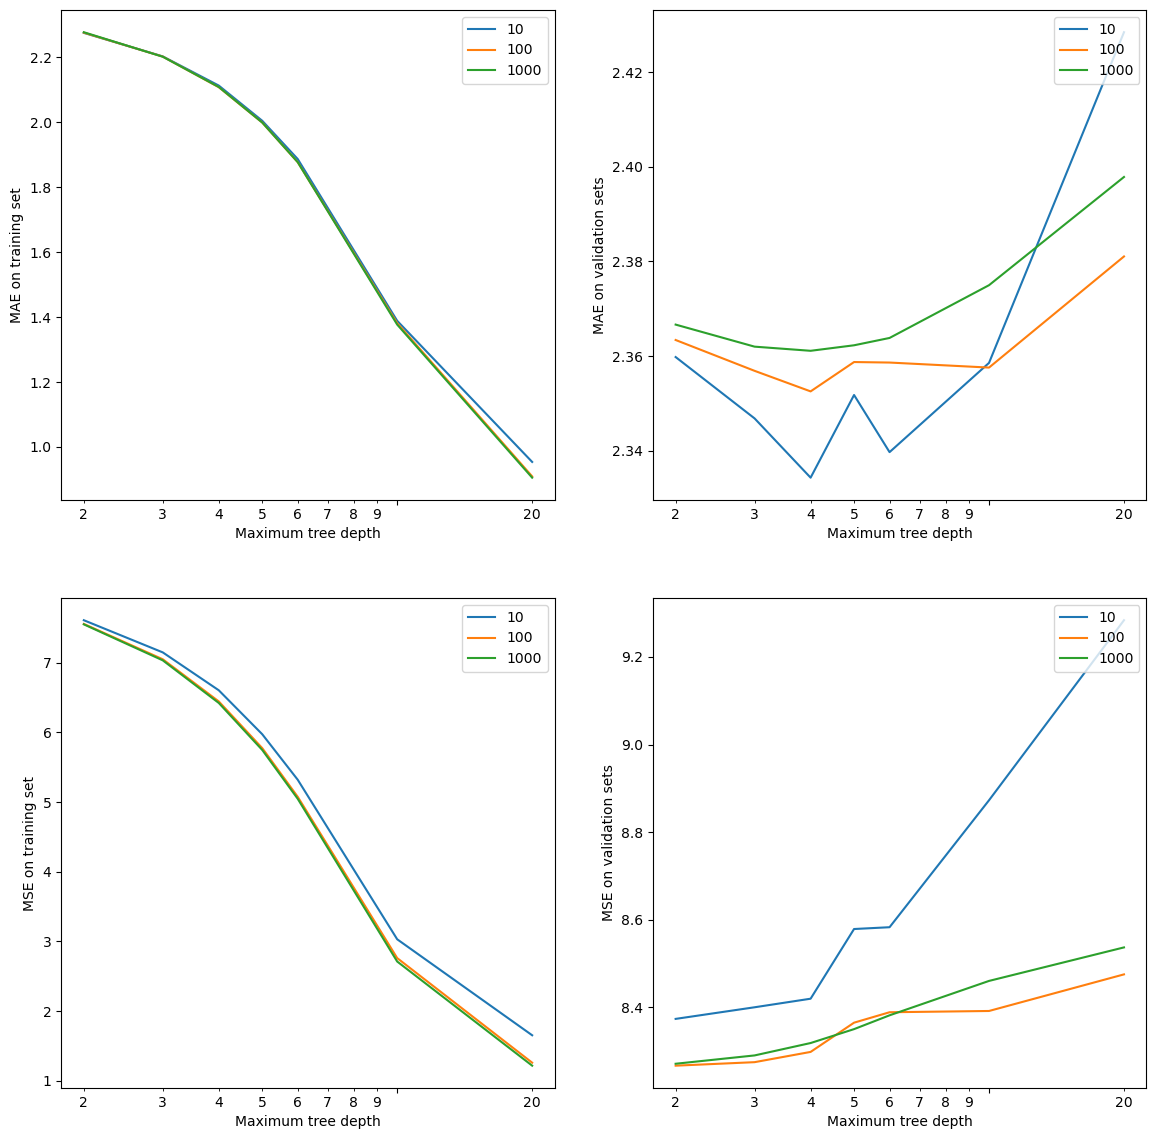

In [519]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 14))
for n in n_estimators:
    ax1.plot(max_depth, mae_rf_cv[n]['train'], label="{}".format(n))
    ax2.plot(max_depth, mae_rf_cv[n]['test'], label="{}".format(n))
    ax3.plot(max_depth, mse_rf_cv[n]['train'], label="{}".format(n))
    ax4.plot(max_depth, mse_rf_cv[n]['test'], label="{}".format(n))
    
ax1.set_xscale('log')
ax1.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
ax1.tick_params(which='major', labelbottom=False)
ax1.set_xlabel('Maximum tree depth')
ax1.set_ylabel('MAE on training set')
legend1 = ax1.legend(loc='upper right')

ax2.set_xscale('log')
ax2.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
ax2.tick_params(which='major', labelbottom=False)
ax2.set_xlabel('Maximum tree depth')
ax2.set_ylabel('MAE on validation sets')
legend2 = ax2.legend(loc='upper right')

ax3.set_xscale('log')
ax3.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
ax3.tick_params(which='major', labelbottom=False)
ax3.set_xlabel('Maximum tree depth')
ax3.set_ylabel('MSE on training set')
legend3 = ax3.legend(loc='upper right')

ax4.set_xscale('log')
ax4.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
ax4.tick_params(which='major', labelbottom=False)
ax4.set_xlabel('Maximum tree depth')
ax4.set_ylabel('MSE on validation sets')
legend4 = ax4.legend(loc='upper right')

plt.show()

In [306]:
# Fit the final random forest regression model
max_depth_final = 10
n_estimators_final = 1000
rf_regr1 = RandomForestRegressor(max_depth=max_depth_final, random_state=0, oob_score=True, n_estimators=n_estimators_final)
rf_regr1.fit(X_train, y_train)

predict_train = rf_regr1.predict(X_train)
predict_test = rf_regr1.predict(X_test)

resid_train = predict_train - y_train
resid_test = predict_test - y_test

mae_rf_train = np.mean(abs(resid_train))
mae_rf_test = np.mean(abs(resid_test))
mse_rf_train = np.mean(resid_train**2)
mse_rf_test = np.mean(resid_test**2)

print("MAE on test set = {}\nMSE on test set = {}".format(mae_rf_test, mse_rf_test))

MAE on test set = 1.3688073266040326
MSE on test set = 4.199005651780417


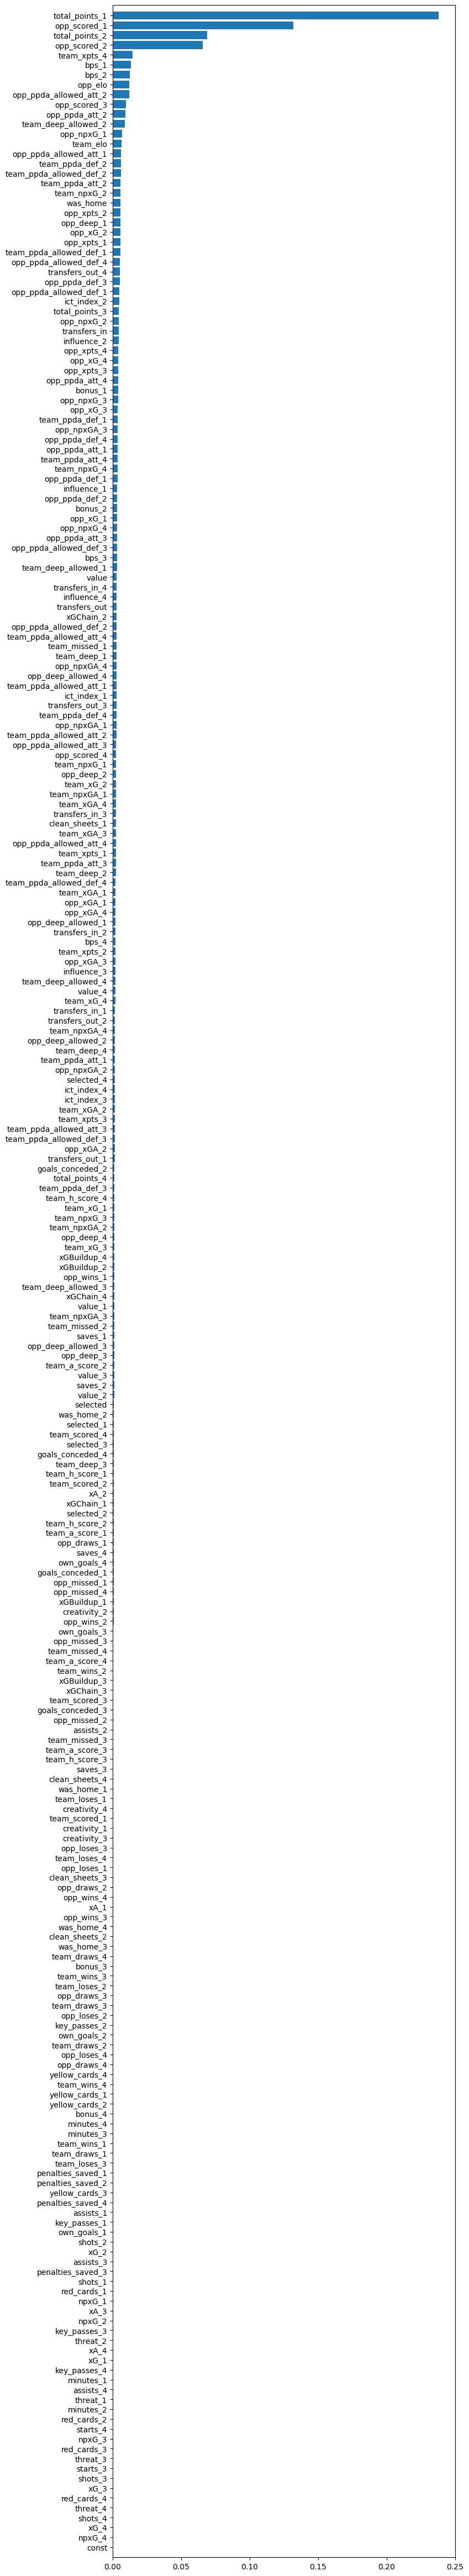

In [307]:
# Examine feature importance
importances = pd.Series(rf_regr1.feature_importances_, index=X_train.columns).sort_values()
fig, ax = plt.subplots(figsize=(8, 60))
ax.margins(y = 0.0025)
ax.barh(importances.index, importances)
plt.show()

In [313]:
importance_threshold = 0.0025
rf_vars_initial = importances[importances >= importance_threshold].index.tolist()
n_vars = len(rf_vars_initial)
print("No. of variables = {}".format(len(importances)))
print("No. of variables above importance threshold = {}".format(len(rf_vars_initial)))

No. of variables = 258
No. of variables above importance threshold = 81


In [311]:
# We will only perform the variable selection CV using variables that are above the importance threshold in the initial model
# since running this for all variables would be time-consuming although theoretically preferred.

# Set up the variable selection cross-validation
Z_train = X_train[rf_vars_initial]
Z_test = X_test[rf_vars_initial]
rf_vars_current = rf_vars_initial.copy()
validation_sets = split(X_train.index, 10)
cv_info = {}

max_depth = 10
n_estimators = 100

while len(rf_vars_current) > 0:
    print(len(rf_vars_current))
    
    cv_info[len(rf_vars_current)] = {}
    cv_info[len(rf_vars_current)]['vars'] = rf_vars_current
    
    Z_train = Z_train[rf_vars_current]
    rf_regr_vs = RandomForestRegressor(max_depth=max_depth,
                                        random_state=0,
                                        oob_score=True,
                                        n_estimators=n_estimators)
    rf_regr_vs.fit(Z_train, y_train)
    
    # Get MAE and MSE estimates using cross-validation
    mae = []
    mse = []
    for validation_idxs in validation_sets:
        Z_train1 = Z_train.drop(validation_idxs, axis=0)
        y_train1 = y_train.drop(validation_idxs)
        Z_val = Z_train.loc[validation_idxs]
        y_val = y_train.loc[validation_idxs]
        
        rf_regr = RandomForestRegressor(max_depth=max_depth,
                                        random_state=0,
                                        oob_score=True,
                                        n_estimators=n_estimators)
        rf_regr.fit(Z_train1, y_train1)
        
        predict_val = rf_regr.predict(Z_val)
        resid_val = predict_val - y_val
        mae.append(np.mean(abs(resid_val)))
        mse.append(np.mean(resid_val**2))
        
    cv_info[len(rf_vars_current)]['mae'] = np.mean(mae)
    cv_info[len(rf_vars_current)]['mse'] = np.mean(mse)

    var_importances = pd.Series(rf_regr_vs.feature_importances_, index=rf_vars_current).sort_values()
    drop_var = var_importances.index[0]
    rf_vars_current.remove(var_importances.index[0])
    
    

['team_xGA_4', 'team_npxGA_1', 'team_xG_2', 'opp_deep_2', 'team_npxG_1', 'opp_scored_4', 'opp_ppda_allowed_att_3', 'team_ppda_allowed_att_2', 'opp_npxGA_1', 'team_ppda_def_4', 'transfers_out_3', 'ict_index_1', 'team_ppda_allowed_att_1', 'opp_deep_allowed_4', 'opp_npxGA_4', 'team_deep_1', 'team_missed_1', 'team_ppda_allowed_att_4', 'opp_ppda_allowed_def_2', 'xGChain_2', 'transfers_out', 'influence_4', 'transfers_in_4', 'value', 'team_deep_allowed_1', 'bps_3', 'opp_ppda_allowed_def_3', 'opp_ppda_att_3', 'opp_npxG_4', 'opp_xG_1', 'bonus_2', 'opp_ppda_def_2', 'influence_1', 'opp_ppda_def_1', 'team_npxG_4', 'team_ppda_att_4', 'opp_ppda_att_1', 'opp_ppda_def_4', 'opp_npxGA_3', 'team_ppda_def_1', 'opp_xG_3', 'opp_npxG_3', 'bonus_1', 'opp_ppda_att_4', 'opp_xpts_3', 'opp_xG_4', 'opp_xpts_4', 'influence_2', 'transfers_in', 'opp_npxG_2', 'total_points_3', 'ict_index_2', 'opp_ppda_allowed_def_1', 'opp_ppda_def_3', 'transfers_out_4', 'opp_ppda_allowed_def_4', 'team_ppda_allowed_def_1', 'opp_xpts_1'

['team_xGA_4', 'team_npxGA_1', 'team_xG_2', 'opp_deep_2', 'team_npxG_1', 'opp_ppda_allowed_att_3', 'opp_npxGA_1', 'team_ppda_def_4', 'transfers_out_3', 'team_ppda_allowed_att_1', 'opp_npxGA_4', 'team_missed_1', 'team_ppda_allowed_att_4', 'opp_ppda_allowed_def_2', 'xGChain_2', 'transfers_out', 'influence_4', 'value', 'team_deep_allowed_1', 'bps_3', 'opp_ppda_allowed_def_3', 'opp_npxG_4', 'opp_xG_1', 'bonus_2', 'opp_ppda_def_2', 'influence_1', 'opp_ppda_def_1', 'team_npxG_4', 'team_ppda_att_4', 'opp_ppda_att_1', 'opp_ppda_def_4', 'opp_npxGA_3', 'team_ppda_def_1', 'opp_xG_3', 'opp_npxG_3', 'bonus_1', 'opp_ppda_att_4', 'opp_xpts_3', 'opp_xG_4', 'opp_xpts_4', 'influence_2', 'transfers_in', 'opp_npxG_2', 'total_points_3', 'ict_index_2', 'opp_ppda_allowed_def_1', 'opp_ppda_def_3', 'transfers_out_4', 'opp_ppda_allowed_def_4', 'team_ppda_allowed_def_1', 'opp_xpts_1', 'opp_xG_2', 'opp_deep_1', 'opp_xpts_2', 'was_home', 'team_npxG_2', 'team_ppda_att_2', 'team_ppda_allowed_def_2', 'team_ppda_def_2

['team_xGA_4', 'team_npxGA_1', 'opp_deep_2', 'team_npxG_1', 'opp_npxGA_1', 'team_ppda_def_4', 'transfers_out_3', 'team_ppda_allowed_att_1', 'opp_npxGA_4', 'team_missed_1', 'team_ppda_allowed_att_4', 'opp_ppda_allowed_def_2', 'xGChain_2', 'transfers_out', 'influence_4', 'value', 'team_deep_allowed_1', 'bps_3', 'opp_ppda_def_2', 'influence_1', 'opp_ppda_def_1', 'team_npxG_4', 'team_ppda_att_4', 'opp_ppda_att_1', 'opp_ppda_def_4', 'opp_npxGA_3', 'team_ppda_def_1', 'opp_xG_3', 'opp_npxG_3', 'bonus_1', 'opp_ppda_att_4', 'opp_xG_4', 'opp_xpts_4', 'influence_2', 'transfers_in', 'opp_npxG_2', 'total_points_3', 'ict_index_2', 'opp_ppda_allowed_def_1', 'opp_ppda_def_3', 'transfers_out_4', 'opp_ppda_allowed_def_4', 'team_ppda_allowed_def_1', 'opp_xpts_1', 'opp_xG_2', 'opp_deep_1', 'opp_xpts_2', 'was_home', 'team_npxG_2', 'team_ppda_att_2', 'team_ppda_allowed_def_2', 'team_ppda_def_2', 'opp_ppda_allowed_att_1', 'team_elo', 'opp_npxG_1', 'team_deep_allowed_2', 'opp_ppda_att_2', 'opp_scored_3', 'opp

['team_xGA_4', 'team_npxGA_1', 'team_npxG_1', 'opp_npxGA_1', 'transfers_out_3', 'team_ppda_allowed_att_1', 'opp_npxGA_4', 'team_missed_1', 'team_ppda_allowed_att_4', 'transfers_out', 'influence_4', 'value', 'influence_1', 'opp_ppda_def_1', 'team_npxG_4', 'team_ppda_att_4', 'opp_ppda_att_1', 'opp_ppda_def_4', 'opp_npxGA_3', 'team_ppda_def_1', 'opp_xG_3', 'opp_npxG_3', 'bonus_1', 'opp_ppda_att_4', 'opp_xG_4', 'opp_xpts_4', 'transfers_in', 'opp_npxG_2', 'total_points_3', 'ict_index_2', 'opp_ppda_allowed_def_1', 'opp_ppda_def_3', 'transfers_out_4', 'opp_ppda_allowed_def_4', 'team_ppda_allowed_def_1', 'opp_xpts_1', 'opp_xG_2', 'opp_deep_1', 'opp_xpts_2', 'was_home', 'team_npxG_2', 'team_ppda_att_2', 'team_ppda_allowed_def_2', 'team_ppda_def_2', 'opp_ppda_allowed_att_1', 'team_elo', 'opp_npxG_1', 'team_deep_allowed_2', 'opp_ppda_att_2', 'opp_scored_3', 'opp_ppda_allowed_att_2', 'opp_elo', 'bps_2', 'bps_1', 'team_xpts_4', 'opp_scored_2', 'total_points_2', 'opp_scored_1', 'total_points_1']
['t

['team_xGA_4', 'team_npxGA_1', 'team_npxG_1', 'transfers_out_3', 'team_ppda_allowed_att_1', 'opp_npxGA_4', 'team_missed_1', 'transfers_out', 'influence_4', 'value', 'influence_1', 'opp_ppda_def_1', 'team_npxG_4', 'opp_npxGA_3', 'opp_xG_3', 'opp_ppda_att_4', 'opp_xG_4', 'opp_xpts_4', 'transfers_in', 'total_points_3', 'ict_index_2', 'opp_ppda_allowed_def_1', 'opp_ppda_def_3', 'transfers_out_4', 'opp_ppda_allowed_def_4', 'team_ppda_allowed_def_1', 'opp_xpts_1', 'opp_xG_2', 'opp_deep_1', 'opp_xpts_2', 'was_home', 'team_npxG_2', 'team_ppda_att_2', 'team_ppda_allowed_def_2', 'team_ppda_def_2', 'opp_ppda_allowed_att_1', 'team_elo', 'opp_npxG_1', 'team_deep_allowed_2', 'opp_ppda_att_2', 'opp_scored_3', 'opp_ppda_allowed_att_2', 'opp_elo', 'bps_2', 'bps_1', 'team_xpts_4', 'opp_scored_2', 'total_points_2', 'opp_scored_1', 'total_points_1']
['team_xGA_4', 'team_npxGA_1', 'team_npxG_1', 'team_ppda_allowed_att_1', 'opp_npxGA_4', 'team_missed_1', 'transfers_out', 'influence_4', 'value', 'influence_1

['team_missed_1', 'influence_4', 'value', 'opp_ppda_def_1', 'team_npxG_4', 'opp_npxGA_3', 'opp_xG_3', 'opp_ppda_att_4', 'opp_xG_4', 'opp_xpts_4', 'transfers_in', 'total_points_3', 'ict_index_2', 'opp_ppda_allowed_def_1', 'transfers_out_4', 'opp_ppda_allowed_def_4', 'team_ppda_allowed_def_1', 'opp_xpts_1', 'opp_xG_2', 'opp_deep_1', 'was_home', 'team_npxG_2', 'team_ppda_att_2', 'team_ppda_allowed_def_2', 'team_ppda_def_2', 'team_elo', 'opp_npxG_1', 'team_deep_allowed_2', 'opp_ppda_att_2', 'opp_scored_3', 'opp_ppda_allowed_att_2', 'opp_elo', 'bps_2', 'bps_1', 'team_xpts_4', 'opp_scored_2', 'total_points_2', 'opp_scored_1', 'total_points_1']
['team_missed_1', 'influence_4', 'value', 'opp_ppda_def_1', 'team_npxG_4', 'opp_npxGA_3', 'opp_xG_3', 'opp_ppda_att_4', 'opp_xG_4', 'opp_xpts_4', 'transfers_in', 'total_points_3', 'ict_index_2', 'opp_ppda_allowed_def_1', 'transfers_out_4', 'opp_ppda_allowed_def_4', 'opp_xpts_1', 'opp_xG_2', 'opp_deep_1', 'was_home', 'team_npxG_2', 'team_ppda_att_2', 't

['opp_ppda_def_1', 'opp_xG_4', 'ict_index_2', 'opp_ppda_allowed_def_1', 'transfers_out_4', 'opp_ppda_allowed_def_4', 'opp_xpts_1', 'opp_xG_2', 'team_npxG_2', 'team_ppda_allowed_def_2', 'team_ppda_def_2', 'team_elo', 'opp_ppda_att_2', 'opp_scored_3', 'opp_ppda_allowed_att_2', 'opp_elo', 'bps_2', 'bps_1', 'team_xpts_4', 'opp_scored_2', 'total_points_2', 'opp_scored_1', 'total_points_1']
['opp_ppda_def_1', 'opp_xG_4', 'ict_index_2', 'opp_ppda_allowed_def_1', 'transfers_out_4', 'opp_ppda_allowed_def_4', 'opp_xpts_1', 'opp_xG_2', 'team_npxG_2', 'team_ppda_allowed_def_2', 'team_elo', 'opp_ppda_att_2', 'opp_scored_3', 'opp_ppda_allowed_att_2', 'opp_elo', 'bps_2', 'bps_1', 'team_xpts_4', 'opp_scored_2', 'total_points_2', 'opp_scored_1', 'total_points_1']
['opp_ppda_def_1', 'opp_xG_4', 'ict_index_2', 'opp_ppda_allowed_def_1', 'transfers_out_4', 'opp_ppda_allowed_def_4', 'opp_xpts_1', 'opp_xG_2', 'team_npxG_2', 'team_ppda_allowed_def_2', 'team_elo', 'opp_ppda_att_2', 'opp_ppda_allowed_att_2', 'o

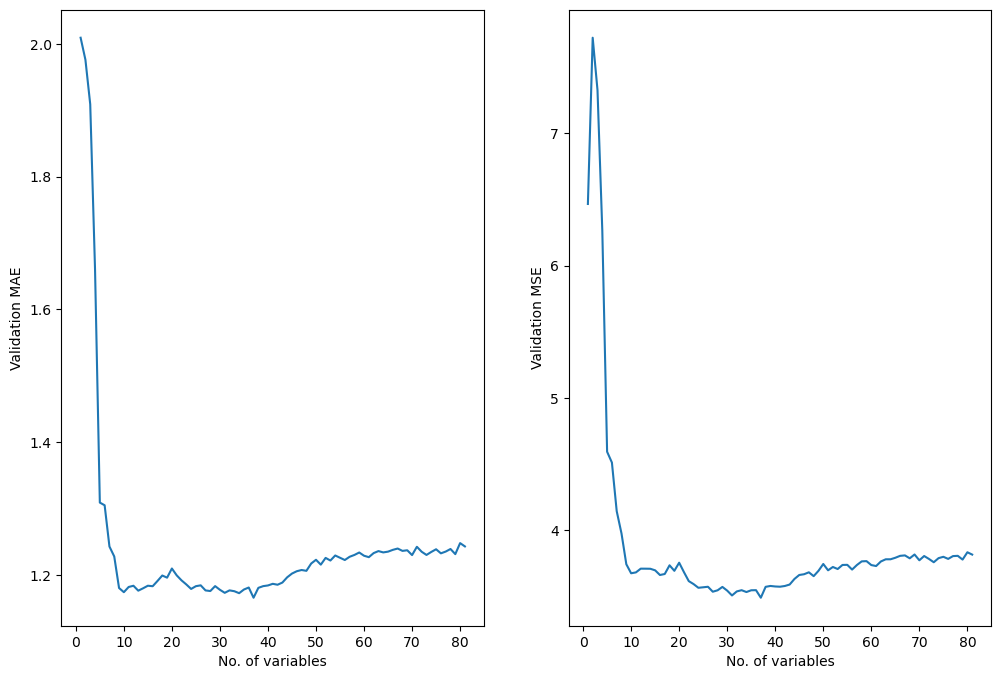

In [320]:
idx = np.linspace(n_vars, 1, n_vars)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.plot(idx, mae_varselect_cv)
ax1.set_xlabel("No. of variables")
ax1.set_ylabel("Validation MAE")
ax2.plot(idx, mse_varselect_cv)
ax2.set_xlabel("No. of variables")
ax2.set_ylabel("Validation MSE")
plt.show()

In [324]:
# Fit the model with 31 variables as the final random forest model
rf_vars_final = ['value', 'opp_ppda_def_1', 'opp_npxGA_3', 'opp_xG_3', 'opp_ppda_att_4', 'opp_xG_4', 'transfers_in',
                 'ict_index_2', 'opp_ppda_allowed_def_1', 'transfers_out_4', 'opp_ppda_allowed_def_4', 'opp_xpts_1',
                 'opp_xG_2', 'team_npxG_2', 'team_ppda_att_2', 'team_ppda_allowed_def_2', 'team_ppda_def_2', 
                 'team_elo', 'opp_npxG_1', 'team_deep_allowed_2', 'opp_ppda_att_2', 'opp_scored_3', 
                 'opp_ppda_allowed_att_2', 'opp_elo', 'bps_2', 'bps_1', 'team_xpts_4', 'opp_scored_2', 
                 'total_points_2', 'opp_scored_1', 'total_points_1']
X_train_rf = X_train[rf_vars_final]

rf_regr_final = RandomForestRegressor(max_depth=20, random_state=0, oob_score=True, n_estimators=n_estimators_final)
rf_regr_final.fit(X_train_rf, y_train)

RandomForestRegressor(max_depth=20, n_estimators=1000, oob_score=True,
                      random_state=0)

In [325]:
rf_predict_final = rf_regr_final.predict(X_test[rf_vars_final])
rf_resid_final = rf_predict_final - y_test
mae_test = np.mean(abs(rf_resid_final))
mse_test = np.mean(rf_resid_final**2)
print("MAE on test set = {:.3f}\nMSE on test set = {:.3f}".format(mae_test, mse_test))

MAE on test set = 1.297
MSE on test set = 4.164
